# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


# Overview

In this project, we analyze the tumor mutation dataset from PanCancer Atlas Initiative https://www.cell.com/pb-assets/consortium/pancanceratlas/pancani3/index.html. This is a cancer dataset comprising over 10,000 patients diagnosed with cancer.  Overall, the study collected diverse and detailed molecular information on each patient's tumor, including DNA sequencing.

#### Primary Dataset
The primary dataset we will be using is the somatic mutations file.  In addition, we may pull some patient features like gender and age at diagnosis from the clinical patient file.

Number of Instances:  3,600,963 somatic mutations for 10,956 cancer patients
Number of Attributes:  ~100 attributes for mutations, ~700 clinical attributes for patients. We will aggregate the mutation data by gene for each patient, reducing the number of attributes by patient to ~ 500-1000 features.

#### Background
By comparing the DNA from normal tissue cells to those of the cancerous cells, somatic mutations can be identified and characterized. Somatic mutations are non-inherited variations to the DNA of a cell that arise during an individual's lifetime. We will use these DNA mutations to predict cancer type, classified into 33 different tissue/organ types.  

#### Motivation
There is clinical value in being able to predict cancer type based on molecular profiles.  For some patients diagnosed with cancer, the biopsied tumor doesn't match the histologic characteristics of the organ/tissue site.  For example, a patient may have a liver tumor that cannot be characterized as liver cells when reviewed by the pathologist.  In these cases, the cancer may have originated from another site and has metastasized to the liver.  This is where genomic tumor data may provide insights by predicting the 'cell of origin', leading to a better-suited therapy for the patient.


# Initialization

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
from textwrap import wrap
import matplotlib.pyplot as plt
from IPython.display import display
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#import xgboost as xgb
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback
#from load_preprocess_data import _preprocess_conv1d



plt.rcParams.update({'figure.max_open_warning': 0})

# Establish the colors for each cancer type
label_colors = []
cm = plt.get_cmap('tab20b')
for i in range(20):
    label_colors.append(cm(i))
cm = plt.get_cmap('tab20c')
for i in range(13):
    label_colors.append(cm(i))


In [10]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [11]:
cd /content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project

/content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project


In [12]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [0]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
# create the directory where the metrics are stored
metrics_dir = "./metrics"
if not os.path.isdir(metrics_dir):
    os.makedirs(metrics_dir)
    
# create the raw where the source data is stored
raw_dir = "./raw"
if not os.path.isdir(raw_dir):
    os.makedirs(raw_dir)    

In [0]:


filename = 'metrics.csv'
if not os.path.isfile('./metrics/' + filename):    
  !wget --directory-prefix=metrics https://w207-final-project.s3.amazonaws.com/metrics/metrics.csv


filename = 'tcga_dictionaries.txt'
if not os.path.isfile('./raw/' + filename):    
  !wget --directory-prefix=raw https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt
   

--2019-07-29 00:34:20--  https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt
Resolving w207-final-project.s3.amazonaws.com (w207-final-project.s3.amazonaws.com)... 52.216.105.195
Connecting to w207-final-project.s3.amazonaws.com (w207-final-project.s3.amazonaws.com)|52.216.105.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81269 (79K) [text/plain]
Saving to: ‘raw/tcga_dictionaries.txt’

tcga_dictionaries.t 100%[===================>]  79.36K  --.-KB/s    in 0.02s   

2019-07-29 00:34:21 (3.47 MB/s) - ‘raw/tcga_dictionaries.txt’ saved [81269/81269]



In [0]:
# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

In [0]:
names = ['all', 'bestfit_100', 'bestfit_700', 'bestfit_1000', 
         'bestfit_med', 'bestfit_large','bestfit_with_topgenes', 'topgenes_small',
         'l1reg_c0.1', 'l1reg_c0.5', 'l1reg_c0.05', 'l1reg_c0.25', 'l1reg_c0.025', 
         'l1reg_c1', 'l1reg_c10', 'l1reg_c100',
         'after_pca']
classifiers = ['lr', 'svm', 'dt', 'rf', 'nn'] 
    

print("Downloads confusion matrix and prf by class")    
for name in names:
  for classifier in classifiers:
    filename = 'confusion_' + name + "_" + classifier + ".csv"
    if not os.path.isfile('./metrics/' + filename):    
      url = 'https://w207-final-project.s3.amazonaws.com/metrics/' + filename
      !wget --directory-prefix=metrics $url
    filename = 'prf_by_class_' + name + "_" + classifier + ".csv"
    
    if not os.path.isfile('./metrics/' + filename):    
      url = 'https://w207-final-project.s3.amazonaws.com/metrics/' + filename
      !wget --directory-prefix=metrics $url
    filename = 'prf_by_class_' + name + "_" + classifier + ".csv"
 
      
print("Downloading data")
for name in names:
  filename = 'features_' + name +  ".train.csv"
  if not os.path.isfile('./data/' + filename):    
    url = 'https://w207-final-project.s3.amazonaws.com/data/' + filename
    !wget --directory-prefix=data $url  
  filename = 'features_' + name +  ".test.csv"
  if not os.path.isfile('./data/' + filename):    
    url = 'https://w207-final-project.s3.amazonaws.com/data/' + filename
    !wget --directory-prefix=data $url      

Downloads confusion matrix and prf by class


# Data Collection
For our analysis of cancer prediction using gene mutation and clinical data from patients, we will gather data from multiple sources. First we obtain the somatic mutation data from the PanCancerAtlas website (https://gdc.cancer.gov/about-data/publications/pancanatlas). We also download the patient clinical data that corresponds to the tumor data. At this time, we are not bringing in clinical features, but as the project progresses, we would like to bring in a few features from this clinical dataset (e.g. age a diagnosis, gender). In our notebook, we store this data locally so that it does not have to be downloaded if the notebook kernel is restarted and run multiple times.

In [0]:
# to make this notebook's output stable across runs
np.random.seed(42)

### Download the somatic mutations file
This file is in the 'MAF' file format, a bioinformatics tab separated format that can contains one record
for each mutation observed in a patient tumor sample.

In [0]:
# This downloads a 753 MB somatic mutations gzip file.  
# This will take about 1-5 mins depending on your
# connection speed.
mutations_filename = "./raw/somatic_mutations.maf.gz"
if os.path.isfile(mutations_filename):
    print("Skipping download, as file %s is present" %(mutations_filename))
else:
    print('Downloading mutation data. 753 MB (may take a few minutes)...')
    url = 'http://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc'  
    urllib.request.urlretrieve(url, mutations_filename)  
print("done.")

Skipping download, as file ./raw/somatic_mutations.maf.gz is present
done.


### Download the patient clinical data

In [0]:
# This downloads an 18 MB patient clinical data file
patient_filename = "./raw/patient_clinical_data.txt"
if os.path.isfile(patient_filename):
    print("Skipping download, as file %s is present" %(patient_filename))
else:
    print('Downloading clinical data ...')  
    url = 'http://api.gdc.cancer.gov/data/0fc78496-818b-4896-bd83-52db1f533c5c'
    urllib.request.urlretrieve(url, patient_filename)  
print("done.")

Skipping download, as file ./raw/patient_clinical_data.txt is present
done.


### Download copy number alterations

In [0]:
# This downloads the copy number alterations file
cna_filename = "./raw/copy_number_alterations.tsv"
if os.path.isfile(cna_filename):
    print("Skipping download, as file %s is present" %(cna_filename))
else:
    print('Downloading copy number alterations ...')
    url = 'https://api.gdc.cancer.gov/data/7d64377f-2cea-4ee3-917f-8fcfbcd999e7'  
    urllib.request.urlretrieve(url, cna_filename)  
print("done.")

('./raw/copy_number_alterations.tsv',
 <http.client.HTTPMessage at 0x7fe3700efb00>)

done.


## Loading Gene Mutation Data ##

Here we read the gene mutation data. This data file contains many columns, but after careful curation, we have decided to consider the following colums:

1. **tumor_sample_barcode**: this contains the barcode with the first 12 characters identifying the patient
2. **gene**: this is the actual gene that has been mutated (for e.g. TACC2, JAKMIP3, PANX3)
3. **gene_type**: this indicates if the gene is protein coding or not.
4. **chromosome**  **start** **end** **Strand**: the chromosome, start position and end position tells us the location of the gene where the mutation is seen.  Strand indicates if it is on the forward or reverse strand of the DNA.
5. **variant_type**: this indicates if it is a single substitution mutation (SNP), a small deletion (DEL), or small insertion (INS), two nucleotide substitution (DNP), three nucleotide substitution (TNP), or more that three nucleotide substitution (ONP)
6. **variant_classification**: this indicates what kind of molecular effect that this mutation will have on the protein.  The most common classes indicate if the substitution causes a change to the amino acid (missense vs silent).  Nonsense mutations cause premature termination of the protein; frameshift mutations cause a misreading of the amino acid sequence.
7. **variant_impact**: this indicates how damaging the mutation -- HIGH, MODERATE, MODIFIER, or LOW.


In [0]:
# Load the mutations dataframe
print('Loading mutations dataframe ...')

mutations = pd.read_csv(mutations_filename, compression='gzip',
                        sep='\t',
                        usecols=['Tumor_Sample_Barcode','Hugo_Symbol', 'BIOTYPE',
                                'Chromosome', 'Start_Position',  'End_Position', 'Strand',
                                'Variant_Type',  'Variant_Classification', 'IMPACT' ])

print("done.")

# Set mutations index
mutations['row'] = np.arange(len(mutations))
mutations.set_index('row', inplace=True)

# Rename the columns to more consistent names
renamed_columns = { 'Tumor_Sample_Barcode': 'tumor_sample_barcode', 
                    'Hugo_Symbol': 'gene', 
                    'BIOTYPE': 'gene_type', 
                    'Chromosome': 'chromosome', 
                    'Start_Position': 'start', 
                    'End_Position': 'end', 
                    'Strand': 'strand', 
                    'Variant_Type': 'variant_type', 
                    'Variant_Classification': 'variant_classification', 
                    'IMPACT': 'variant_impact'}
mutations.rename(renamed_columns, inplace=True, axis=1)


print("\nMutations count:       ", mutations.tumor_sample_barcode.count())
print("Number of unique samples:", mutations.tumor_sample_barcode.nunique())
mutations.head(5)

Loading mutations dataframe ...


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done.

Mutations count:        3600963
Number of unique samples: 10295


,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact
row,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE


The actual cancer type can be found by parsing the tumor sample barcode and then looking up
the cancer type code in the dictionary based on the tissue source site portion of the
tumor sample barcode

In [0]:
# Parse the tissue source site from the tumor sample barcode.  Then use the
# tissue site source to lookup the cancer type from the tcga_dictionaries
def parse_cancer_type(tumor_sample_barcode):
    tss = tumor_sample_barcode.split("-")[1] #Extra the tissue source site from the tcga_id
    cancer_type = disease_to_code[tissue_source_site[tss][1]][0] #Convert from tss to disease to code 
    return cancer_type


mutations['cancer_type'] = mutations['tumor_sample_barcode'].apply(parse_cancer_type)
print("Number of unique cancer types:", mutations.cancer_type.nunique())


# Get the patient barcode.  This is what we will use to join the mutations to the clinical data
def parse_patient_barcode(tumor_sample_barcode):
        return tumor_sample_barcode[0:12]
  
mutations['patient_barcode'] = mutations['tumor_sample_barcode'].apply(parse_patient_barcode)
#mutations = mutations.drop(['tumor_sample_barcode'], axis=1)
#mutations = mutations.drop(['cancer_type'], axis=1)
print("Number of unique patients:", mutations['patient_barcode'].nunique())

Number of unique cancer types: 33
Number of unique patients: 10224


## Loading Patient Data##

Here we load the clinical data. This is data for patients for whom we collected the gene mutation data above. The patients are identified by $patient\_barcode$. We will use this field to populate the gene mutation data from the dataframe above in the table we are about to read. The clinical data has patient information such as gender and age at diagnosis.

Loading clinical dataframe ...
Clinical count 10956


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,patient_barcode,cancer_type,gender,age_at_initial_pathologic_diagnosis
0,TCGA-OR-A5J1,ACC,MALE,58
1,TCGA-OR-A5J2,ACC,FEMALE,44
2,TCGA-OR-A5J3,ACC,FEMALE,23
3,TCGA-OR-A5J4,ACC,FEMALE,23
4,TCGA-OR-A5J5,ACC,MALE,30



Number of cancer types 32
Number of patients 10956


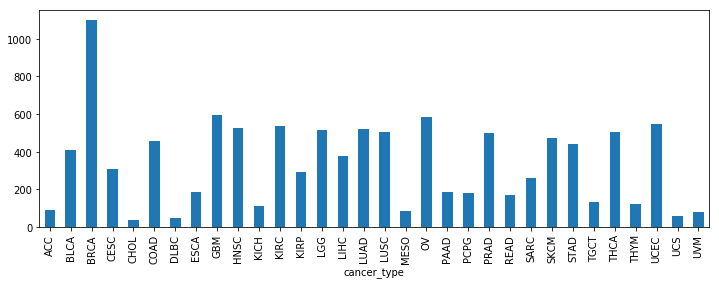

In [0]:
# Load the clinical data
print('Loading clinical dataframe ...')
clinical = pd.read_csv(patient_filename, sep='\t',
                        usecols=['bcr_patient_barcode', 'acronym', 'gender', 
                                 'age_at_initial_pathologic_diagnosis'])

# Rename the columns to more consistent names
renamed_columns = { 'bcr_patient_barcode': 'patient_barcode', 
                    'acronym': 'cancer_type' }
clinical.rename(renamed_columns, inplace=True, axis=1)

print('Clinical count', clinical.patient_barcode.count())
display(clinical.head(5))

# Get cancer types
cancer_types = clinical['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))

# Get number of cases per cancer type
group_by_patient = clinical.groupby(['cancer_type'])['patient_barcode'].nunique()
print("Number of patients", group_by_patient.sum())
group_by_patient.plot.bar(figsize=(12,4))

## Loading Copy Number Alterations Data ##

Here we read the copy number alterations data. This data file contains a row for every copy number alteration with the following columns

1. **gene**: The gene of the copy number alteration
2. **Locus ID**: This is the chromosomal coordinate of the copy number alteration
3. **Cytoband**: this indicates region of the Chromosome that the copy number alteration exists
4. The remaining columns are the tumor sample barcode.  

In [0]:
# Load the copy number alterations
print('Loading copy number alterations ...')
cna_source = pd.read_csv(cna_filename, sep='\t')

# Rename the columns to more consistent names
renamed_columns = { 'Gene Symbol': 'gene' }
cna_source.rename(renamed_columns, inplace=True, axis=1)


print('Number of patient tumors', len(cna_source.columns) - 3)

# Get number of genes
print("Number of genes across all tumors", cna_source.gene.nunique())

Loading copy number alterations ...
Number of patient tumors 10713
Number of genes across all tumors 25128


In [0]:
cna_source.drop(["Locus ID", "Cytoband"], axis=1, inplace=True)
cna = cna_source.T

# The first row becomes the column headers
gene_names = cna.iloc[0]
cna.columns = gene_names.values
cna.drop(cna.index[0], inplace=True)

cna.index.names = ['id']
cna['patient_sample_barcode'] = cna.index


# Get the patient barcode.  This is what we will use to join the mutations to the clinical data
def parse_patient_barcode(patient_sample_barcode):
    return patient_sample_barcode[0:12]
    
cna['patient_barcode'] = cna.patient_sample_barcode.apply(parse_patient_barcode) 

print(cna.patient_barcode.nunique())
print(cna.shape[0])

def parse_cancer_type(patient_sample_barcode):
    tss = patient_sample_barcode.split("-")[1] #Extra the tissue source site from the tcga_id
    cancer_type = disease_to_code[tissue_source_site[tss][1]][0] #Convert from tss to disease to code 
    return cancer_type

cna['cancer_type'] = cna['patient_sample_barcode'].apply(parse_cancer_type) 
cna.drop(['patient_sample_barcode'], axis=1, inplace=True)
display(cna.head())

10713
10713


,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,C1orf233,C1orf86,CALML6,CCNL2,CDK11A,CDK11B,CPSF3L,DDX11L1,DVL1,FAM132A,FAM138A|chr1,FAM213B,FAM41C,FAM87B,GABRD,GLTPD1,GNB1,HES4,HES5,ISG15,KIAA1751,KLHL17,LINC00115,LINC00982,LINC01128,LOC100129534,LOC100130417,LOC100133331|chr1,LOC100133445,LOC100288069,...,PLXNA3,LAGE3,UBL4A,SLC10A3,FAM3A,G6PD,IKBKG,BRCC3,CLIC2,CMC4,CTAG1A,CTAG2,DKC1,F8A1,F8A2,F8,FAM223A,FUNDC2,GAB3,H2AFB1,H2AFB2,MIR1184-1,MIR1184-2,MIR1184-3,MIR644B,MPP1,MTCP1,RAB39B,RP13-228J13.1,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,DDX11L16|chrX,IL9R|chrX,SPRY3|chrX,VAMP7|chrX,patient_barcode,cancer_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TCGA-OR-A5J1,ACC
TCGA-OR-A5J2-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J2,ACC
TCGA-OR-A5J3-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J3,ACC
TCGA-OR-A5J4-01A-11D-A29H-01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TCGA-OR-A5J4,ACC
TCGA-OR-A5J5-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J5,ACC


In [0]:

col_rename = {}
for col in cna.columns:
  if (col != 'patient_barcode' and col != 'cancer_type' and not(col.endswith("_cna"))):
    col_rename[col] = col + "_cna"

cna.rename(col_rename, axis=1, inplace=True)
display(cna.head())

,ACAP3_cna,ACTRT2_cna,AGRN_cna,ANKRD65_cna,ATAD3A_cna,ATAD3B_cna,ATAD3C_cna,AURKAIP1_cna,B3GALT6_cna,C1orf159_cna,C1orf233_cna,C1orf86_cna,CALML6_cna,CCNL2_cna,CDK11A_cna,CDK11B_cna,CPSF3L_cna,DDX11L1_cna,DVL1_cna,FAM132A_cna,FAM138A|chr1_cna,FAM213B_cna,FAM41C_cna,FAM87B_cna,GABRD_cna,GLTPD1_cna,GNB1_cna,HES4_cna,HES5_cna,ISG15_cna,KIAA1751_cna,KLHL17_cna,LINC00115_cna,LINC00982_cna,LINC01128_cna,LOC100129534_cna,LOC100130417_cna,LOC100133331|chr1_cna,LOC100133445_cna,LOC100288069_cna,...,PLXNA3_cna,LAGE3_cna,UBL4A_cna,SLC10A3_cna,FAM3A_cna,G6PD_cna,IKBKG_cna,BRCC3_cna,CLIC2_cna,CMC4_cna,CTAG1A_cna,CTAG2_cna,DKC1_cna,F8A1_cna,F8A2_cna,F8_cna,FAM223A_cna,FUNDC2_cna,GAB3_cna,H2AFB1_cna,H2AFB2_cna,MIR1184-1_cna,MIR1184-2_cna,MIR1184-3_cna,MIR644B_cna,MPP1_cna,MTCP1_cna,RAB39B_cna,RP13-228J13.1_cna,SMIM9_cna,SNORA36A_cna,SNORA56_cna,TMLHE_cna,VBP1_cna,DDX11L16|chrX_cna,IL9R|chrX_cna,SPRY3|chrX_cna,VAMP7|chrX_cna,patient_barcode,cancer_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TCGA-OR-A5J1,ACC
TCGA-OR-A5J2-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J2,ACC
TCGA-OR-A5J3-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J3,ACC
TCGA-OR-A5J4-01A-11D-A29H-01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TCGA-OR-A5J4,ACC
TCGA-OR-A5J5-01A-11D-A29H-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCGA-OR-A5J5,ACC


## Creating Merged Data ##

Now that we have both gene and cancer data in one dataframe, and the patient clinical data in another dataframe, we will use the **patient_barcode** to merge these into a single table. With this, we can drop the tumor_sample_barcode column, since it has served its purpose. Looking at the data, it seems like some patient data is missing from the gene data. Simultaneously, some data in the gene dataframe does not have corresponding clinical data. Hence our merged dataframe size will be lower than the original mutations dataframe size.

In [0]:
clinical['patient_barcode'].isnull().values.any()

False

In [0]:
missing_count = 0
gene_barcode_set = set(mutations.patient_barcode.unique())
for bc in gene_barcode_set:
    if bc not in set(clinical.patient_barcode.unique()):
        missing_count += 1
print("%d patients with gene data missing in clinical data" %missing_count)

216 patients with gene data missing in clinical data


In [0]:
merged = mutations.merge(clinical, left_on='patient_barcode', right_on='patient_barcode')
print('Merged mutations count:   ', merged.patient_barcode.count())
print('Number of unique patients:', merged.patient_barcode.nunique())
merged.rename({'cancer_type_x': 'cancer_type'}, axis=1, inplace=True)
print('Number of cancer types:   ', merged.cancer_type.nunique())


Merged mutations count:    3570876
Number of unique patients: 10008
Number of cancer types:    32


In [0]:
fileName = "./data/mutations_with_clinical.csv"
print("  writing", fileName, "...")
merged.to_csv(fileName)
print("  done.")

fileName = "./data/mutations.csv"
print("  writing", fileName, "...")
mutations.to_csv(fileName)
print("  done.")

  writing ./data/mutations_with_clinical.csv ...
  done.
  writing ./data/mutations.csv ...
  done.


In [0]:
clinical_patient_barcode = set(clinical.patient_barcode.unique())
mutation_patient_barcode = set(mutations.patient_barcode.unique())
cna_patient_barcode = set(cna.patient_barcode.unique())

missing_clin     = clinical_patient_barcode - cna_patient_barcode
missing_cna      = mutation_patient_barcode - cna_patient_barcode
missing_mutation = cna_patient_barcode - mutation_patient_barcode

print("%d cna patients missing from clinical" %len(missing_clin))
print("%d cna patients missing from mutations" %len(missing_cna))
print("%d mutation patients missing from cna" %len(missing_mutation))


#merged_cna = cna.merge(clinical, left_on='patient_barcode', right_on='patient_barcode')
#print('Merged cna :   ', merged_cna.patient_barcode.count())
#print('Number of unique patients:', merged_cna.case_id.nunique())
#print('Number of cancer types:   ', merged_cna.cancer_type.nunique())

fileName = "./data/cna.csv"
print("  writing", fileName, "...")
cna.to_csv(fileName)
print("  done.")

467 cna patients missing from clinical
410 cna patients missing from mutations
899 mutation patients missing from cna
  writing ./data/cna.csv ...
  done.


### Eliminate non-coding genes. 

This is a common filter in bioinformatics analysis, eliminating genes that do not code for proteins.  

In [0]:
mutations.gene_type.unique()

array(['protein_coding', 'transcribed_unprocessed_pseudogene',
       'IG_V_gene', 'processed_transcript', 'lincRNA', 'miRNA',
       'TR_V_gene', 'antisense', 'snoRNA', 'IG_C_gene',
       'nonsense_mediated_decay', 'TR_C_gene', 'rRNA',
       'polymorphic_pseudogene', 'retained_intron', 'TR_J_gene', 'snRNA',
       'unprocessed_pseudogene', 'sense_overlapping', 'misc_RNA',
       'transcribed_processed_pseudogene', 'processed_pseudogene',
       'sense_intronic', '3prime_overlapping_ncrna', 'pseudogene',
       'IG_J_gene', 'IG_D_gene', 'unitary_pseudogene'], dtype=object)

In [0]:
# Eliminate psuedo genes
psuedo_genes = list(['transcribed_unprocessed_pseudogene',
               'polymorphic_pseudogene', 
               'unprocessed_pseudogene', 
               'transcribed_processed_pseudogene', 'processed_pseudogene',
               'pseudogene', 'unitary_pseudogene'])

before_count               = mutations.gene.nunique()
mutations_coding           = mutations[~mutations.gene_type.isin(psuedo_genes)]
after_count                = mutations.gene.nunique()
print("Filtered out ", str(before_count - after_count), "genes")



Filtered out  0 genes


### Split the data into training and test datasets
Split the data into a training and test split.  We will use a split of 80% training, 20% test.  
We will split based on the patient_barcode.  As part of feature engineering, we will be 
aggregating mutations, so that each example will be represented as a patient (tumor), with
columns for each gene.

In [0]:
#
# Split the patients into training and test
#
def split_patient_data(data):
    patient_data = data.patient_barcode.unique()

    le     = preprocessing.LabelEncoder()
    patient_labels_string = data.groupby('patient_barcode')['cancer_type'].nunique()
    patient_labels = le.fit_transform(patient_labels_string)
    
    print("Number of unique patients:           ", patient_data.shape[0])
    print("Number of labels for unique patients:", len(patient_labels))
    
    train_data, test_data, train_labels, test_labels = train_test_split(
                                                               patient_data, patient_labels,
                                                               stratify=patient_labels, 
                                                               test_size=0.20)



    print("\ntraining patients:  ", train_data.shape[0])
    print("test patients:      ", test_data.shape[0])
    return {'train_patients': train_data, 'test_patients': test_data}



In [0]:

#
#  Split Mutations data (based on patient split) and 
#  write out data files
#
def split_and_save_mutation_data(split):
    
    train_patients = split['train_patients']
    test_patients  = split['test_patients']

    train_mutations = mutations[mutations.patient_barcode.isin(train_patients)]
    test_mutations  = mutations[mutations.patient_barcode.isin(test_patients)]
    print("\ntraining data:      ", train_mutations.shape[0])
    print("test data:          ", test_mutations.shape[0])
    print("\nall data:           ", test_mutations.shape[0])
    print("train + test:       ", test_mutations.shape[0] + test_mutations.shape[0])
    
    # Write out mutations training data as csv file
    print("\nWriting training set ...")
    train_mutations.to_csv("./data/somatic_mutations_train.csv")
    print("done.")

    # Write out mutations test data as csv file
    print("\nWriting test set ...")
    test_mutations.to_csv("./data/somatic_mutations_test.csv")
    print("done.")

   
split = split_patient_data(mutations)   
split_and_save_mutation_data(split)

Number of unique patients:            10224
Number of labels for unique patients: 10224

training patients:   8179
test patients:       2045

training data:       2924873
test data:           676090

all data:            676090
train + test:        1352180

Writing training set ...
done.

Writing test set ...
done.


In [0]:

#
#  Split copy number alterations data (based on patient split) and 
#  write out data files
#
def split_and_save_cna_data(split, description):
    
    train_patients = split['train_patients']
    test_patients  = split['test_patients']

    train_cna = cna[cna.patient_barcode.isin(train_patients)]
    test_cna  = cna[cna.patient_barcode.isin(test_patients)]
    print("\ntraining cna data:      ", train_cna.shape[0])
    print("test cna data:          ", test_cna.shape[0])
    print("\nall cna data:           ", cna.shape[0])
    print("train + test cna:       ", train_cna.shape[0] + test_cna.shape[0])
    
    # Write out cna training data as csv file
    print("\nWriting cna training set ...")
    train_cna.to_csv("./data/cna_train." + description + ".csv")
    print("done.")

    # Write out cna test data as csv file
    print("\nWriting cna test set ...")
    test_cna.to_csv("data/cna_test." + description + ".csv")
    print("done.")


split_and_save_cna_data(split, "with_mut")

split_cna = split_patient_data(cna)   
split_and_save_cna_data(split_cna, "alone")


training cna data:       7869
test cna data:           1945

all cna data:            10713
train + test cna:        9814

Writing cna training set ...
done.

Writing cna test set ...
done.
Number of unique patients:            10713
Number of labels for unique patients: 10713

training patients:   8570
test patients:       2143

training cna data:       8570
test cna data:           2143

all cna data:            10713
train + test cna:        10713

Writing cna training set ...
done.

Writing cna test set ...
done.


# EDA and Feature Selection



In [0]:
# Remove old features_ files
#filenames = glob.glob('./data/features_*.csv')
 
# Iterate over the list of filepaths & remove each file.
#for filePath in filenames:
#    try:
#        os.remove(filePath)
#    except OSError:
#        print("Error while deleting file")

Here, we open the data we put together in the previous notebook. For the first analysis, we look at $cancer\_type$, $patient\_barcode$, $gene$ and $gene_type$.

In [13]:
print('Loading data ...')
mutations = {}
mutations['train'] = pd.read_csv("./data/somatic_mutations_train.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
mutations['test']  = pd.read_csv("./data/somatic_mutations_test.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
print("done.")
print("Mutations training data count:", mutations['train']['patient_barcode'].count())
print("Mutations test data count:    ", mutations['test']['patient_barcode'].count())

Loading data ...
done.
Mutations training data count: 2924873
Mutations test data count:     676090


In [0]:
print('Loading cna data ...')
cna = {}
cna['train'] = pd.read_csv("./data/cna_train.alone.csv")
cna['test']  = pd.read_csv("./data/cna_test.alone.csv")
print("done.")
print("CNA training data count:", cna['train']['patient_barcode'].count())
print("CNA test data count:    ", cna['test']['patient_barcode'].count())

Loading cna data ...
done.
CNA training data count: 8570
CNA test data count:     2143


### Show distribution of genes across patient tumors

Sample by Gene Frequency
  mean number of genes per patient tumor: 277
  min  number of genes per patient tumor: 1
  max  number of genes per patient tumor: 13954


Text(0.5, 0, 'Genes')

Text(0, 0.5, 'Sample Frequency')

Text(0.5, 1.0, 'How many genes are mutated in a tumor sample?')

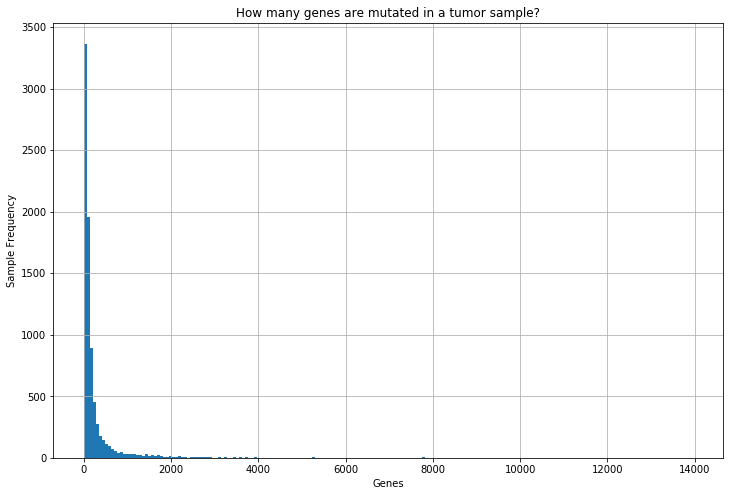

Genes by patient frequency
  mean number of sample tumors a gene is mutated across: 106
  min  number of sample tumors a gene is mutated across:  1
  max  number of sample tumors a gene is mutated across:  3125


Text(0.5, 0, 'Number of Samples')

Text(0, 0.5, 'Gene Frequency')

Text(0.5, 1.0, 'Genes mutated across multiple samples')

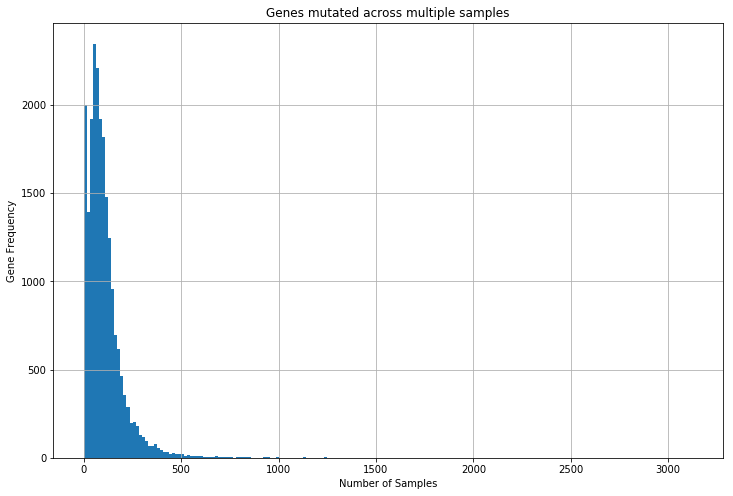


Genes by cancer type frequency
  mean: 17
  min:  1
  max:  33


Text(0.5, 0, 'Number of Cancer Types')

Text(0, 0.5, 'Gene Frequency')

Text(0.5, 1.0, 'Genes are common across many cancer types')

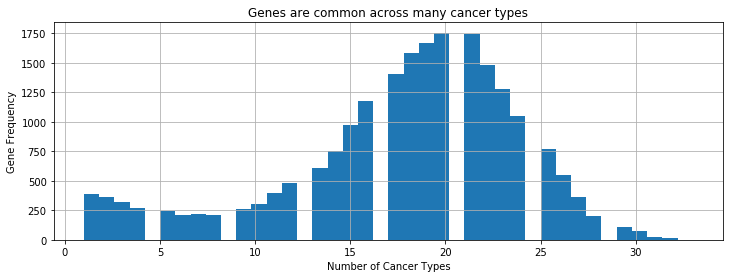

In [150]:
# Show how many genes are
group1         = mutations['train'].groupby(['patient_barcode'])['gene'].nunique().reset_index(name='count')
group1.columns = ['patient', 'gene_count']
group1_count   = group1.sort_values(['gene_count', 'patient'], ascending=[0,1])
print('Sample by Gene Frequency')
print("  mean number of genes per patient tumor:", int(group1_count['gene_count'].mean()))
print("  min  number of genes per patient tumor:", int(group1_count['gene_count'].min()))
print("  max  number of genes per patient tumor:", int(group1_count['gene_count'].max()))

ax = group1_count['gene_count'].hist(bins=200, figsize=(12,8))
ax.set_xlabel("Genes")
ax.set_ylabel("Sample Frequency")
ax.set_title("How many genes are mutated in a tumor sample?")
plt.show()



# Show the distribution of genes across patient tumors
gene_count         = mutations['train'].groupby(['gene'])['patient_barcode'].nunique().reset_index(name='count')
gene_count.columns = ['gene', 'patient_count']
gene_count         = gene_count.sort_values(['patient_count', 'gene'], ascending=[0,1])
print('Genes by patient frequency')
print("  mean number of sample tumors a gene is mutated across:", int(gene_count['patient_count'].mean()))
print("  min  number of sample tumors a gene is mutated across: ", int(gene_count['patient_count'].min()))
print("  max  number of sample tumors a gene is mutated across: ", int(gene_count['patient_count'].max()))

ax = gene_count['patient_count'].hist(bins=200, figsize=(12,8))
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Gene Frequency")
ax.set_title("Genes mutated across multiple samples")
plt.show()

gene_cc_count         = mutations['train'].groupby(['gene'])['cancer_type'].nunique().reset_index(name='count')
gene_cc_count.columns = ['gene', 'cancer_type_count']
gene_cc_count         = gene_cc_count.sort_values(['cancer_type_count', 'gene'], ascending=[0,1])
print('\nGenes by cancer type frequency')
print("  mean:", int(gene_cc_count['cancer_type_count'].mean()))
print("  min: ", int(gene_cc_count['cancer_type_count'].min()))
print("  max: ", int(gene_cc_count['cancer_type_count'].max()))


ax = gene_cc_count['cancer_type_count'].hist(bins=40, figsize=(12,4))
ax.set_xlabel("Number of Cancer Types")
ax.set_ylabel("Gene Frequency")
ax.set_title("Genes are common across many cancer types")
plt.show()

From the histogram above, it is clear that even through we have a large number of genes, only a small number of them are turned on in the patient tumor data that we have. This is the classic problem of a large feature space with a much smaller number of samples. Hence we will need to perform a dimensionality reduction technique such as PCA here.


Number of cancer types: 33

Number of patients: 8179


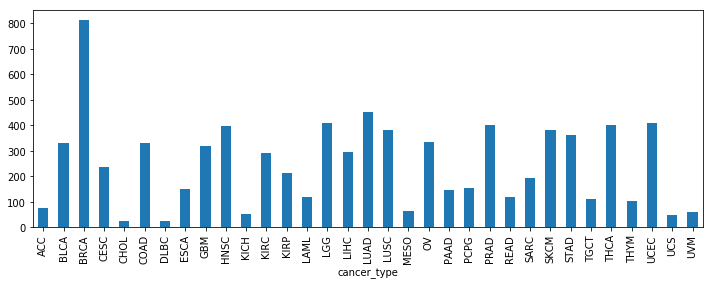

In [13]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['train'].cancer_type.unique()
print("\nNumber of cancer types:", len(cancer_types))

# Get number of cases per cancer type
group_patients_by_cancer = mutations['train'].groupby(['cancer_type'])['patient_barcode'].nunique()
print("\nNumber of patients:", group_patients_by_cancer.sum())
group_patients_by_cancer.plot.bar(figsize=(12,4))

The above chart shows that there are some cancers, such as BRCA and LUAD that have a large representation in our dataset, but other such as DBLC and UCS that are present in much smaller numbers. This will present a challenge for our classifier. Specifically, we want our classifier to be able to classify each of the 32 types of cancers with high precision, but the model should also be able to identify the cancers that don't have a proportionate representation in our data set. It could be that these are cancers are rare, or perhaps they are simply rare in our dataset. **Note:** add more details about the cancers that are abundant as well as rare in this dataset.

Mean number of genes represented for each cancer type: 11379
Min number of genes represented for each cancer type:  891
Max number of genes represented for each cancer type:  20914


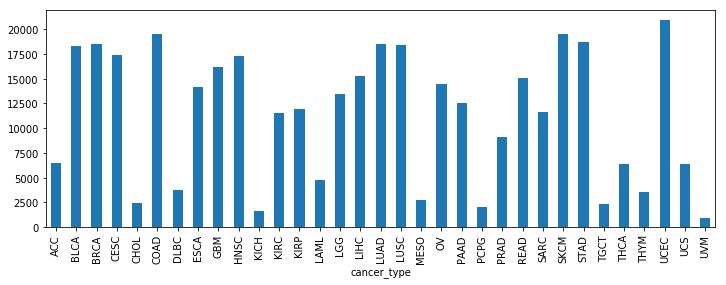

In [14]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations['train'].groupby(['cancer_type'])['gene'].nunique();
group_genes_by_cancer.plot.bar(figsize=(12,4))
print("Mean number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.mean())))
print("Min number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.min())))
print("Max number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.max())))

The above bar chart gives us an idea of how many genes (features for us) are _on_ for each of the cancer types. Cross referencing this chart with the previous one, we see that for some cancers such as DLBC and UCS we have a fair number of active features, even though the number of cases of such cancers are low. We should be able to person isolated (one-vs-rest) analysis for these cases. However, for other cancers, such as KICH (Kidney Chromophobe) and UVM (Uveal Melanoma) we have both a low occurance rate, and a low number of active features. This second category of cancers will need to be handled with care.

## Functions for feature engineering

In [0]:
# Create feature matrix each row is a patient tumor; each column is a gene
def create_patient_x_gene_matrix(mutations, feature_genes, description, save=True):
    cases = list()
    grouped = mutations.groupby('patient_barcode')
    i = int(0)

    cols = ['case_id', 'cancer_type']
    for gene in feature_genes:
        cols.append(gene)


    for name, group in grouped:
        case = list()
        case.append(name)
        for cc in group.cancer_type.head(1):
            case.append(cc)

        for gene_flag in feature_genes.isin(group.gene.unique()):
            switch = 0
            if gene_flag == True:
                switch = 1
            case.append(switch)
        cases.append(case)


    cases_df = pd.DataFrame(cases)
    cases_df.columns = cols
    print("  ", cases_df.shape)
    
    # Write out transformed data to csv
    if save:
        fileName = "./data/" + description + ".csv"
        print("  writing", fileName, "...")
        cases_df.to_csv(fileName)
        print("  done.")
    
    return cases_df


In [0]:
def show_genes_across_cancer_types(top_gene_cancer_matrix, top_n_gene_count, total_gene_count):
    plt.rcParams["figure.figsize"] = (10,4)
    sums_by_cancer_type = top_gene_cancer_matrix.sum(axis=1, skipna=True, numeric_only=True) 
    sorted = sums_by_cancer_type.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'patient_count']
    df.reset_index()    
    title = 'Patient counts for genes (top ' + str(top_n_gene_count) + ')';
    ax = df.head(50).plot.bar(x='gene', y='patient_count', legend=None, title=title)

    cancer_type_present_count = top_gene_cancer_matrix.astype(bool).sum(axis=1, skipna=True, numeric_only=True)
    sorted = cancer_type_present_count.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'present_in_cancer_type_count']
    df.reset_index()    

    axarr = df.hist(bins=32)

    for ax in axarr.flatten():
        ax.set_xlabel("Number of cancer types gene is present")
        ax.set_ylabel("Gene frequency")
    
    return df

### Somatic mutation using top n genes

In [0]:

def create_feature_matrix(mutations_train, mutations_test, top_n_gene_count, save, description, charts=True):
    print("Formatting gene matrix with top ", top_n_gene_count, "genes from each cancer type")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    
    

    # Now find the top n genes for each cancer type
    top_genes = []
    idx = 0

    plt.rcParams["figure.figsize"] = (20,20)
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        top_rows = sorted_genes[sorted_genes > 0].head(top_n_gene_count)
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is gene, column for each cancer type
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    print("  number of genes:", top_gene_cancer_matrix.shape[0])
    if charts:
        show_genes_across_cancer_types(top_gene_cancer_matrix, 
                                   top_n_gene_count, 
                                   top_gene_cancer_matrix.shape[0] )
    feature_genes = top_gene_cancer_matrix.index
    print("  number of genes after filter:", len(feature_genes))
    create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save)
    create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save)

### All somatic mutations

In [0]:
def create_all_feature_matrix(mutations_train, mutations_test, save, description):
    print("Formatting gene matrix with for all features")
    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = pd.Series(mutations_train.gene.unique())
    feature_matrix_train = create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save)
    feature_matrix_test  = create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save)
    return feature_matrix_train, feature_matrix_test

### KBestFit

In [0]:
def get_best_fit_features(feature_matrix, n_features):
    #apply SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    
    data = feature_matrix.loc[:, (feature_matrix.columns != 'cancer_type') & (feature_matrix.columns != 'case_id')]
    labels_string = feature_matrix['cancer_type']
    
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)
    
    fit = bestfeatures.fit(data,labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    
    #concat two dataframes for better visualization 
    scores_df = pd.concat([dfcolumns,dfscores], axis=1)
    scores_df.columns = ['gene', 'score']
    sorted_scores = scores_df.sort_values(by=['score', 'gene'], ascending=[0,1])
    display(sorted_scores.head())
    return sorted_scores.gene.values
  
def create_best_fit_feature_matrix(feature_matrix_train, feature_matrix_test,  
                               save, description):
  
    #
    #  Try BestFit (chi squared test) to find most
    #  important genes
    #
    k_best_fits = [100, 700, 1000, 5000, 8000]
    print("Running KBestFit")
    best_genes_ranked  = get_best_fit_features(feature_matrix_train, 8000)
    
    print("  done.")
    
    for k_best in k_best_fits:
      print("Creating gene matrix with best fit for", k_best, "features")
      best_genes = best_genes_ranked[:k_best]
      print(len(best_genes))
      
      cancer_type = feature_matrix_train['cancer_type']
      case_id     = feature_matrix_train['case_id']
      data_train  = feature_matrix_train.loc[:, feature_matrix_train.columns.isin(best_genes)]
      final_feature_matrix_train = pd.concat([case_id, cancer_type, data_train], axis=1)

      cancer_type = feature_matrix_test['cancer_type']
      case_id     = feature_matrix_test['case_id']
      data_test   = feature_matrix_test.loc[:, feature_matrix_test.columns.isin(best_genes)]
      final_feature_matrix_test = pd.concat([case_id, cancer_type, data_test], axis=1)

      if save:
          fileName = "./data/" + description  + "_" + str(k_best) + ".train.csv"
          print("  writing", fileName, "...")
          print(" ", final_feature_matrix_train.shape)
          final_feature_matrix_train.to_csv(fileName)
          print("  done.")        

          fileName = "./data/" + description  + "_" + str(k_best) + ".test.csv"
          print("  writing", fileName, "...")
          print(" ", final_feature_matrix_test.shape)
          final_feature_matrix_test.to_csv(fileName)
          print("  done.")        

### Lasso regularization 

In [0]:
def create_l1_feature_matrix(train_features, test_features, label_encoder, description, save):
    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)

    params = {'C':  [100, 10, 1, .5, .25, .1, .05, .025 ]}
    
    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
        # Fit model
        l1.fit(train_data, train_labels) 


        # Get the features with non-zero coefficients.  We will use
        # this list to reduce the features 
        non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
        names = np.array(list(train_data.columns))
        non_zero_genes = names[non_zero_sums] 


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        trimmed_train_data = train_data[non_zero_genes]
        trimmed_test_data  = test_data[non_zero_genes]
        
        final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
        final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
        
        if save:
            fileName = "./data/" + description + "_c" + str(c_param) + ".train.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_train.shape)
            final_features_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description + "_c" + str(c_param) + ".test.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_test.shape)
            final_features_test.to_csv(fileName)
            print("  done.")        
        


### RFE

In [0]:
def create_rfe_feature_matrix(train_features, test_features, label_encoder, 
                              classifier, n_features, n_step,
                              description, save):

    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)
    

    rfe = RFE(estimator=classifier, n_features_to_select=n_features, step=n_step, verbose=3)
    rfe.fit(train_data, train_labels)
    
    trimmed_train_data = train_data[train_data.columns[rfe.support_]]
    trimmed_test_data  = test_data[test_data.columns[rfe.support_]]
    
    final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
    final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
    
    
    if save:
      fileName = "./data/" + description +  ".train.csv"
      print("  writing", fileName, "...")
      print(" ", final_features_train.shape)
      final_features_train.to_csv(fileName)
      print("  done.")        

      fileName = "./data/"+ description + ".test.csv"
      print("  writing", fileName, "...")
      print(" ", final_features_test.shape)
      final_features_test.to_csv(fileName)
      print("  done.")        
     
    
    return final_features_train, final_features_test



### Copy number alterations feature engineering

In [0]:
def create_l1_cna_features(train_features, test_features, label_encoder, description, save):
    
   
    train_patient_barcode = train_features.patient_barcode
    train_cancer_type     = train_features.cancer_type
    train_labels          = label_encoder.fit_transform(train_features.cancer_type)
    train_data            = train_features[train_features.columns[~train_features.columns.isin(['id', 'case_id','patient_barcode', 'cancer_type'])]]

    test_patient_barcode = test_features.patient_barcode
    test_cancer_type     = test_features.cancer_type
    test_labels          = label_encoder.fit_transform(test_features.cancer_type)
    test_data            = test_features[test_features.columns[~test_features.columns.isin(['id', 'case_id','patient_barcode', 'cancer_type'])]]


    params = {'C':  [.01, .025]}
    
    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
        print("lr fit")

        # Fit model
        l1.fit(train_data, train_labels) 

        print("non zero coefs")

        # Get the features with non-zero coefficients.  We will use
        # this list to reduce the features 
        non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
        names = np.array(list(train_data.columns))
        non_zero_genes = names[non_zero_sums] 


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        trimmed_train_data = train_data[non_zero_genes]
        trimmed_test_data  = test_data[non_zero_genes]
        
        final_features_train = pd.concat([train_patient_barcode, train_cancer_type, trimmed_train_data], axis=1)
        final_features_test =  pd.concat([test_patient_barcode, test_cancer_type, trimmed_test_data], axis=1)
        
        if save:
            fileName = "./data/" + description + "_c" + str(c_param) + ".train.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_train.shape)
            final_features_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description + "_c" + str(c_param) + ".test.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_test.shape)
            final_features_test.to_csv(fileName)
            print("  done.")    
            
        


## Create different feature sets

### All genes

Create a feature matrix,  Feature matrix will have one row per patient tumor, 
column for every gene encountered in training data set.

In [18]:
feature_matrix_train, feature_matrix_test = create_all_feature_matrix(mutations['train'], 
                                                                   mutations['test'], True, 'features_all')

Formatting gene matrix with for all features
   (8179, 21283)


KeyboardInterrupt: ignored

### Top n genes most frequent in each cancer type

Create a feature matrix, getting the top n genes that are most frequent
per label (cancer type).  Merge these genes and create a feature matrix,
one row per patient tumor, column for each merged gene

In [0]:
create_feature_matrix(mutations['train'], mutations['test'], 1000, True, 'features_topgenes_small')

### KBestFit 

Create a feature matrix, using sklearn BestFit to find top 100, 700, 1000, 5000, 8000 genes. Feature matrix will have one row per patient tumor, column for each 'bestfit' gene



In [24]:
create_best_fit_feature_matrix(feature_matrix_train, feature_matrix_test, True, 
                          'features_bestfit')


Running KBestFit


,gene,score
491,IDH1,3940.533094
14079,VHL,2712.372858
3038,BRAF,2549.393736
1667,APC,2441.610415
2840,KRAS,1951.835814


  done.
Creating gene matrix with best fit for 100 features
100
  writing ./data/features_bestfit_100.train.csv ...
  (8179, 102)
  done.
  writing ./data/features_bestfit_100.test.csv ...
  (2045, 102)
  done.
Creating gene matrix with best fit for 700 features
700
  writing ./data/features_bestfit_700.train.csv ...
  (8179, 702)
  done.
  writing ./data/features_bestfit_700.test.csv ...
  (2045, 702)
  done.
Creating gene matrix with best fit for 1000 features
1000
  writing ./data/features_bestfit_1000.train.csv ...
  (8179, 1002)
  done.
  writing ./data/features_bestfit_1000.test.csv ...
  (2045, 1002)
  done.
Creating gene matrix with best fit for 5000 features
5000
  writing ./data/features_bestfit_5000.train.csv ...
  (8179, 5002)
  done.
  writing ./data/features_bestfit_5000.test.csv ...
  (2045, 5002)
  done.
Creating gene matrix with best fit for 8000 features
8000
  writing ./data/features_bestfit_8000.train.csv ...
  (8179, 8002)
  done.
  writing ./data/features_bestfit_

### Logistic Regression (L1)

Trim the features using Logistic Regression, L1 regularization

In [0]:
label_encoder            = preprocessing.LabelEncoder()
create_l1_feature_matrix(feature_matrix_train, feature_matrix_test, label_encoder,
           'features_l1reg', True)

  writing ./data/features_l1reg_c0.025.train.csv ...
  (8179, 59)
  done.
  writing ./data/features_l1reg_c0.025.test.csv ...
  (2045, 59)
  done.
  writing ./data/features_l1reg_c0.05.train.csv ...
  (8179, 187)
  done.
  writing ./data/features_l1reg_c0.05.test.csv ...
  (2045, 187)
  done.
  writing ./data/features_l1reg_c0.1.train.csv ...
  (8179, 580)
  done.
  writing ./data/features_l1reg_c0.1.test.csv ...
  (2045, 580)
  done.
  writing ./data/features_l1reg_c0.25.train.csv ...
  (8179, 2254)
  done.
  writing ./data/features_l1reg_c0.25.test.csv ...
  (2045, 2254)
  done.
  writing ./data/features_l1reg_c0.5.train.csv ...
  (8179, 4692)
  done.
  writing ./data/features_l1reg_c0.5.test.csv ...
  (2045, 4692)
  done.
  writing ./data/features_l1reg_c1.train.csv ...
  (8179, 7570)
  done.
  writing ./data/features_l1reg_c1.test.csv ...
  (2045, 7570)
  done.
  writing ./data/features_l1reg_c10.train.csv ...
  (8179, 15131)
  done.
  writing ./data/features_l1reg_c10.test.csv ...

### RFE

In [0]:
label_encoder            = preprocessing.LabelEncoder()

svm = LinearSVC(penalty='l2', C=0.1)
lr = LogisticRegression(penalty='l1', C=0.1)

n_features = [100, 800, 4000, 8000]
n_step = .05

label_encoder            = preprocessing.LabelEncoder()

for n_feature in n_features:
    
  _,_ = create_rfe_feature_matrix(feature_matrix_train, 
                           feature_matrix_test,
                           label_encoder,
                           svm, n_feature, n_step,
                           'features_rfe_svm_'  + str(n_feature),
                           True)
  _,_ = create_rfe_feature_matrix(feature_matrix_train, 
                         feature_matrix_test,
                         label_encoder,
                         lr, n_feature, n_step,
                         'features_rfe_lr_'  + str(n_feature),
                         True)


### PCA for dimensionality reduction

In [0]:
pca = PCA()
all_features_train = feature_matrix_train.drop(columns=['case_id', 'cancer_type'])
pca.fit(all_features_train)
ev = np.cumsum(pca.explained_variance_ratio_)
evcount = len(ev[ev<99.0])
print("Number of features that explain 99% of the variance: ", evcount)
pca = PCA(n_components=evcount)
pca.fit(all_features_train)
train_PCA = pca.transform(all_features_train)
all_features_test = feature_matrix_test.drop(columns=['case_id', 'cancer_type'])
test_PCA = pca.transform(all_features_test)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Number of features that explain 99% of the variance:  8179


PCA(copy=True, iterated_power='auto', n_components=8179, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
train_PCA_df = pd.DataFrame(train_PCA)
train_PCA_df['case_id'] = feature_matrix_train['case_id']
train_PCA_df['cancer_type'] = feature_matrix_train['cancer_type']

test_PCA_df = pd.DataFrame(test_PCA)
test_PCA_df['case_id'] = feature_matrix_test['case_id']
test_PCA_df['cancer_type'] = feature_matrix_test['cancer_type']

#reorder columns and write out
for df, f_name in zip( (train_PCA_df, test_PCA_df), 
                      ('./data/features_after_pca.train.csv', './data/features_after_pca.test.csv') ):
  cols = df.columns.tolist()
  cols = cols[-2:] + cols[:-2]
  df = df[cols]
  df.to_csv(f_name)


### Copy Number Alterations feature matrix

In [0]:
def cna_encode_binary(data):
  print("Encoding cna data into binary...")
  cols  = []
  for col in data.columns[1:-2]:
   
    cols.append(col + "_pos")
    cols.append(col + "_neg")

  
  
  rows  = []
  for index, data_row in data.iterrows():    
    row = []
    for val in data_row.values[1:-2]:
      
      bin_pos = 0
      bin_neg = 0
      if int(val) > 0:
        bin_pos = 1
      elif int(val) < 0:
        bin_neg = 1
      row.append(bin_pos)
      row.append(bin_neg)
    
    
    rows.append(row)

  cna_binary = pd.DataFrame(rows, columns=cols)
  print(" done.")
  return cna_binary

def merge_mut_and_cna(mut_name, cna_name, description):
  print("Loading mutations train...")
  train_mutations = pd.read_csv("./data/features_" + mut_name + ".train.csv")
  print("Loading mutations test...")
  test_mutations  = pd.read_csv("./data/features_" + mut_name + ".test.csv")     

  print("mut train:         ", train_mutations.shape)
  print("mut test:          ",test_mutations.shape)
  print("mut train patients:",train_mutations.case_id.nunique())
  print("mut test patients:",test_mutations.case_id.nunique())

  print("\nLoading cna binary train...")
  train_binary_cna = pd.read_csv("./data/temp_" + cna_name + ".train.csv")
  print("Loading cna binary test...")
  test_binary_cna  = pd.read_csv("./data/temp_" + cna_name + ".test.csv")     

  print("cna train:         ", train_binary_cna.shape)
  print("cna test:          ",test_binary_cna.shape)
  print("cna train patients:",train_binary_cna.patient_barcode.nunique())
  print("cna test patients:",test_binary_cna.patient_barcode.nunique())

  train_binary_cna.rename({'patient_barcode': 'case_id'}, inplace=True, axis=1)
  test_binary_cna.rename({'patient_barcode': 'case_id'}, inplace=True, axis=1)

  merged_train = train_mutations.merge(train_binary_cna, left_on='case_id', right_on='case_id', how='left')
  merged_test  = test_mutations.merge(test_binary_cna, left_on='case_id', right_on='case_id', how='left')

  merged_train.rename({'cancer_type_x': 'cancer_type'}, axis=1, inplace=True)
  merged_train.drop(merged_train.columns[0], axis=1, inplace=True)
  merged_train.drop('cancer_type_y', axis=1, inplace=True)
  merged_train.fillna(0, inplace=True)

  merged_test.rename({'cancer_type_x': 'cancer_type'}, axis=1, inplace=True)
  merged_test.drop(merged_test.columns[0], axis=1, inplace=True)
  merged_test.drop('cancer_type_y', axis=1, inplace=True)
  merged_test.fillna(0, inplace=True)

  fileName = "./data/" + description + ".train.csv"
  print("  writing", fileName, "...")
  merged_train.to_csv(fileName)
  print("  done.")

  fileName = "./data/" + description + ".test.csv"
  print("  writing", fileName, "...")
  merged_test.to_csv(fileName)
  print("  done.")
  
merge_mut_and_cna("l1reg_c0.25", "cna_binary_tomerge_l1reg_c0.025", "features_mutations_and_cna" )
merge_mut_and_cna("l1reg_c0.25", "cna_binary_tomerge_l1reg_c0.01" , "features_mutations_and_cna_sm" )


In [0]:
#cna = {}
#print("Loading cna train...")
#cna['train'] = pd.read_csv("./data/cna_train.alone.csv")
#print("Loading cna test...")
#cna['test'] = pd.read_csv("./data/cna_test.alone.csv")

#
# CNA feature elimination using L1
#
#

label_encoder            = preprocessing.LabelEncoder()

create_l1_cna_features(cna['train'], cna['test'], label_encoder, 
                       description="features_cna_l1reg", save=True)



#
#  DNA Binary matrix
#
#
train_binary_cna = cna_encode_binary(cna['train'])
test_binary_cna  = cna_encode_binary(cna['test'])

train_binary_cna["patient_barcode"] = cna['train'].patient_barcode
test_binary_cna["patient_barcode"]  = cna['test'].patient_barcode

train_binary_cna["cancer_type"] = cna['train'].cancer_type
test_binary_cna["cancer_type"]  = cna['test'].cancer_type

create_l1_cna_features(train_binary_cna, test_binary_cna, label_encoder, 
                       description="features_cna_binary_l1reg", save=True)


#
# Merge CNA and Somatic Mutations
#
#

print("Loading cna train...")
train_cna = pd.read_csv("./data/cna_train.with_mut.csv")
print("Loading cna test...")
test_cna = pd.read_csv("./data/cna_test.with_mut.csv")

train_binary_cna = cna_encode_binary(train_cna)
test_binary_cna  = cna_encode_binary(test_cna)

train_binary_cna["patient_barcode"] = train_cna.patient_barcode
test_binary_cna["patient_barcode"]  = test_cna.patient_barcode

train_binary_cna["cancer_type"] = train_cna.cancer_type
test_binary_cna["cancer_type"]  = test_cna.cancer_type

create_l1_cna_features(train_binary_cna, test_binary_cna, label_encoder, 
                       description="temp_cna_binary_tomerge_l1reg", save=True)


# Run the Classifiers

## Load the data

### The data dictionary
All data source files are downloaded above.  This dataset, is a data dictionary
that will allow us to translate cancer type codes to cancer type names.

In [0]:
# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

In [0]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_barcode columns 
    data = features[features.columns[3:]]

    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

In [208]:
print('Loading training data ...')
# label encoder
label_encoder   = preprocessing.LabelEncoder()

# get all file names that start with features_
train_files = glob.glob("./data/features_after_pca*.train.csv")
all_train_data = {}

# load all of the files
for filename in train_files:
    
    name = filename[16:-10]
    print(" ", name)
    train_features = pd.read_csv(filename)
    all_train_data[name] = getDataAndLabels(name, train_features, label_encoder)

print("done.")

Loading training data ...
  after_pca
done.


In [209]:
print('Loading test data ...')

test_files = glob.glob("./data/features_after_pca*.test.csv")
all_test_data = {}
for filename in test_files:
    
    name = filename[16:-9]
    #if (name != 'after_pca'):
    print(" ", name)
    test_features = pd.read_csv(filename)
    all_test_data[name] = getDataAndLabels(name, test_features, label_encoder)

print("done.")

Loading test data ...
  after_pca
done.


## Functions for tracking metrics

In [0]:
def get_saved_metrics():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        metrics =  [row for row in metrics_df.T.to_dict().values()]
        return metrics
    else:
        return []
      
def get_saved_metrics_dataframe():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        return metrics_df
    else:
        return None

def save_metrics(name, classifier, metrics, prf_by_label, confusion_mx):
    
    metrics_df = pd.DataFrame(metrics, columns=['name', 'classifier', 'feature_size', 
                                                'accuracy', 'precision', 'recall', 'f1', 
                                                'time'])
    
    # Write out scores as csv files
    metrics_df.to_csv("./metrics/metrics.csv")
    
    # Write out confusion matrix to csv file    
    confusion_mx_df = pd.DataFrame.from_dict(confusion_mx)
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    confusion_mx_df.to_csv(filename)
    
    # Write out precision, recall, f1 by class to csv file
    prf_by_label_df = pd.DataFrame(prf_by_label)
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    prf_by_label_df.to_csv(filename)
    
def get_prf_by_label(name, classifier):
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        prf_by_label_df = pd.read_csv(filename)
        return prf_by_label_df[prf_by_label_df.columns[1:]]
    else:
        return None
    
def get_confusion_matrix(name, classifier):
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        confusion_df = pd.read_csv(filename)
        return confusion_df[confusion_df.columns[1:]]
    else:
        return None
      
def calculate_metrics(name, classifier, feature_size, predict, test_labels, 
                      elapsed_time, metrics):
    # Get precision, recall, f1 scores
    prf_scores          = precision_recall_fscore_support(test_labels, predict, 
                                                          average='weighted')
    acc_score           = accuracy_score(test_labels, predict)
    prf_by_label        = precision_recall_fscore_support(test_labels, predict, 
                                                          average=None)
    classification_rpt  = classification_report(test_labels, predict)

    # Get confusion matrix
    conf_mx             = confusion_matrix(test_labels, predict)

    metrics.append({
     'name':               name,
     'classifier':         classifier,
     'feature_size':       feature_size,
     'accuracy':           acc_score,
     'precision':          prf_scores[0],
     'recall':             prf_scores[1],
     'f1':                 prf_scores[2],
     'time':               elapsed_time 
    })
    save_metrics(name, classifier, metrics, prf_by_label, conf_mx)



## Functions for running different classifiers

In [0]:
#
# Logistic regression
# 
def getBestParamsLogit(train_data, train_labels):
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.1, 0.25,  0.5]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

def run_logistic_regression(train_data, train_labels, test_data, test_labels, 
                            name, hyper_params, metrics, forcerun=False):
  
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'lr']
    if (not(forcerun) and len(existing) > 0):
      print("\nLogistic Regression (skipping)")
      return
    
    print("\nLogistic Regression", name)

    start = time.process_time()
    if name in hyper_params and 'lr' in hyper_params[name]:
        best_params_logit = hyper_params[name]['lr']
    else:
        print("Running grid search on Logistic Regression...")
        best_params_logit = getBestParamsLogit(train_data, train_labels)

    # Run logistic regression with L2 regularization on reduced
    # feature set
    lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                          C=best_params_logit['C'], 
                          solver="liblinear", multi_class="ovr")
    lr.fit(train_data, train_labels) 
    predict = lr.predict(test_data)
    elapsed_time = time.process_time() - start


    calculate_metrics(name, 'lr', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)

    print(" done.")
    
    return

In [0]:
#
# Linear SVM
#

def getBestParamsSVM(train_data, train_labels):
    #
    # SVM
    #
    classifier = LinearSVC(penalty='l2')

    params = {'C': [0.01, 0.1, 0.5]}
    svm = GridSearchCV(classifier, params, cv=4, 
                       scoring='accuracy', return_train_score=True)

    # Fit  training data
    svm.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', svm.best_params_)
    print(' Accuracy:  ', np.round(svm.best_score_, 4) )
    
    return svm.best_params_
  
def run_linear_svm(train_data, train_labels, test_data, test_labels, 
                   name, hyper_params, metrics, forcerun=False):
    
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'svm']
    if (not(forcerun) and len(existing) > 0):
      print("\nLinear SVM (skipping)")
      return
    
    print("\nLinear SVM", name)
    start = time.process_time()
    if name in hyper_params and 'svm' in hyper_params[name]:
        best_params_svm = hyper_params[name]['svm']
    else:
        print("Running grid search on Linear SVM...")
        best_params_svm = getBestParamsSVM(train_data, train_labels)

    svm = LinearSVC(penalty='l2', C=best_params_svm['C'])

    svm.fit(train_data, train_labels,) 
    predict = svm.predict(test_data)
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'svm', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)
    
    print(" done.")
    return

In [0]:
#
# Decision tree
#
def run_decision_tree(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):

    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'dt']
    if (len(existing) > 0):
      print("\nDecision Tree (skipping)")
      return
    
    print("\nDecision Tree", name)
    start = time.process_time()
    dt = DecisionTreeClassifier()
    
    dt.fit(train_data, train_labels,) 
    predict = dt.predict(test_data)
    elapsed_time = time.process_time() - start


    calculate_metrics(name, 'dt', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)
    
    print(" done.")
    return

In [0]:
#
# Random forest
#
def run_random_forest(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):
  
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'rf']
    if (len(existing) > 0):
      print("\nRandom Forest (skipping)")
      return
    
    print("\nRandom Forest", name)
    start = time.process_time()
    rf = RandomForestClassifier(n_estimators=500)
    
    rf.fit(train_data, train_labels,) 
    predict = rf.predict(test_data)
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'rf', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)
    
    print(" done.")
    return

In [0]:
def plot_neural_net_epochs(name, history):
    
    plt.rcParams["figure.figsize"] = (15,4)
    
    fig, axlist = plt.subplots(1,2)
    ax = axlist.flatten()
    
    

    labels = np.arange(1, len(history['loss'])+1, 1)

    ax[0].plot(labels, history['loss'], color='blue', 
             linewidth=1, label="Loss (train)",  )
    ax[0].plot(labels, history['val_loss'], color='orange', 
             linewidth=1, label="Loss (test)", )

    ax[0].set_ylabel('Loss', fontsize=20)
    ax[0].set_xlabel('Epoch', fontsize=20, labelpad=20)
    ax[0].set_title(name + " Loss")
    ax[0].legend()
    ax[0].grid()


    labels = np.arange(1, len(history['acc'])+1, 1)

    ax[1].plot(labels, history['acc'], color='blue', 
             linewidth=1, label="Accuracy (train)", )
    ax[1].plot(labels, history['val_acc'], color='orange', 
             linewidth=1, label="Accuracy (test)",  )

    ax[1].set_ylabel('Accuracy', fontsize=20)
    ax[1].set_xlabel('Epoch', fontsize=20, labelpad=20)
    ax[1].set_title(name + " Accuracy")
    ax[1].legend()
    ax[1].grid()

    
    plt.savefig("./metrics/nn_epochs_" + name + "_.pdf", dpi=150, format="pdf")

In [0]:

#
# Neural Net
#
def run_neural_net(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'nn']
    if (len(existing) > 0):
      print("\nNeural Net (skipping)")
      return
    
    print("\nNeural Net", name)
    tr_lab = to_categorical(train_labels)
    test_lab = to_categorical(test_labels)
    
    number_of_classes = len(tr_lab[0])
    
    start = time.process_time()
    model = K.Sequential()
    model.add(Dense(2000, input_dim=train_data.shape[1], activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l2=0.01,l1=0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ["accuracy"])
    
    
    #model.fit(train_data, tr_lab, epochs=200, batch_size=100)
    if name == 'after_pca':
      n_epochs = 10
    else:
      n_epochs = 140
    hist = model.fit(train_data, tr_lab, epochs=n_epochs, batch_size=100,
                     validation_data=(test_data, test_lab))
    
    plot_neural_net_epochs(name, hist.history)
    
    evaluate = model.evaluate(x = test_data, y = test_lab)
    predict = model.predict(test_data)    
    
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'nn', train_data.shape[1],
                      np.argmax(predict,1), test_labels, elapsed_time, metrics)

    print(" done.")
    
    
    return


## Run the different classifiers 

************************
after_pca
************************

Logistic Regression (skipping)

Linear SVM (skipping)

Decision Tree (skipping)

Random Forest (skipping)

Neural Net after_pca
Train on 8179 samples, validate on 2045 samples
Epoch 1/10
8179/8179 [==============================] - 7s 798us/sample - loss: 280.7198 - acc: 0.0886 - val_loss: 25.3709 - val_acc: 0.1017
Epoch 2/10
8179/8179 [==============================] - 5s 670us/sample - loss: 24.8934 - acc: 0.0985 - val_loss: 24.9618 - val_acc: 0.1017
Epoch 3/10
8179/8179 [==============================] - 5s 645us/sample - loss: 24.1062 - acc: 0.0990 - val_loss: 23.5839 - val_acc: 0.1017
Epoch 4/10
8179/8179 [==============================] - 5s 644us/sample - loss: 23.7080 - acc: 0.0989 - val_loss: 23.7459 - val_acc: 0.1017
Epoch 5/10
8179/8179 [==============================] - 5s 625us/sample - loss: 23.9223 - acc: 0.1012 - val_loss: 24.2158 - val_acc: 0.1017
Epoch 6/10
8179/8179 [==============================] - 5s 640

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done.


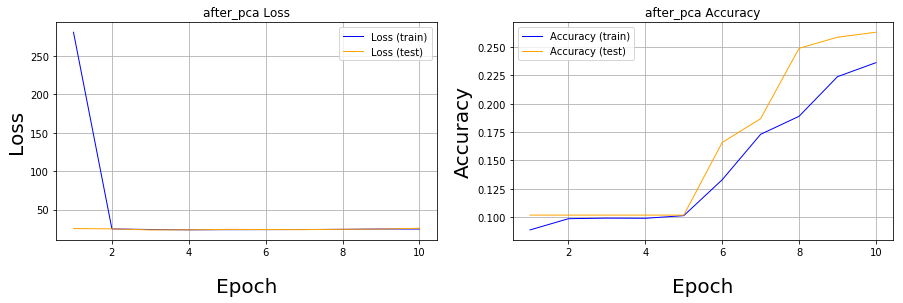

In [226]:
hyper_params = {
    'mutations_and_cna_sm': {'lr': {'C': .1}, 'svm': {'C': 100}},
    'mutations_and_cna':    {'lr': {'C': .1}, 'svm': {'C': 100}},
    'cna_alone':            {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'cna_l1reg_c0.01':      {'lr': {'C': 0.01}, 'svm': {'C': 0.01}},
    'cna_l1reg_c0.025':     {'lr': {'C': 0.01}, 'svm': {'C': 0.01}},
    'cna_binary_l1reg_c0.01':  {'lr': {'C': 0.01}, 'svm': {'C': 0.01}},
    'cna_binary_l1reg_c0.025': {'lr': {'C': 0.01}, 'svm': {'C': 0.01}},
    'l1reg_c0.5':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c1':             {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c10':            {'lr': {'C': 0.1},  'svm': {'C': 0.01}},
    'l1reg_c100':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'topgenes_small':       {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_med':          {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'bestfit_large':        {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'all':                  {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_with_topgenes':{'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'after_pca':            {'lr': {'C': 0.5 }, 'svm': {'C': 0.01}}
}

metrics = get_saved_metrics()


for name in all_train_data.keys():
    print("************************")
    print(name)
    print("************************")

    train      = all_train_data[name]
    test       = all_test_data[name]
    
    

    run_logistic_regression(train['data'], train['labels'], test['data'], test['labels'], 
                            name, hyper_params, metrics, forcerun=False)
    
    run_linear_svm(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics, forcerun=False)

    run_decision_tree(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    run_random_forest(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    run_neural_net(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    

## Visualize Performance across different feature sets, different classifiers

In [0]:
colors = {'lr': 'olivedrab', 'svm': 'slateblue', 
          'dt': 'mediumseagreen', 'rf': 'goldenrod',
          'xgb': 'coral', 'nn': 'crimson'}

def plot_classifier_metrics(metrics_df, label_encoder, description):
    
    plt.rcParams["figure.figsize"] = (14,14)

    labels = []
    for key, group in metrics_df.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + '\n' + key[1])
    

    sorted_df_report = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


        
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.precision.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " precision", marker='o' )
        plt.plot(labels, group.recall.values, color=colors[classifier], linestyle="dashed",
                 linewidth=2, label=classifier + " recall", marker='o' )
    

    plt.yticks(np.arange(0, .70, .01))
    plt.title(description, fontsize=20)
    plt.ylabel('Precision, Recall', fontsize=14)
    plt.xlabel('Feature Sets', fontsize=14, labelpad=14)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.grid()
    plt.show()
    
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.accuracy.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " accuracy", marker='o' )
    

    plt.yticks(np.arange(0, .70, .01))
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(rotation='vertical')
    plt.xlabel('Features and Classifiers', fontsize=14, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_classifier_times(metrics_df, label_encoder, description):
    
    plt.rcParams["figure.figsize"] = (14,6)

    labels = []
    for key, group in metrics_df.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + '\n' + key[1])
        
    sorted_df_report = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


        
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.time.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " precision", marker='o' )
        
    

    plt.ylabel('Time to train and predict', fontsize=14)
    plt.xlabel('Feature Sets', fontsize=14, labelpad=14)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.grid()
    plt.show()
    

    
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)
  


### Load the metrics data

In [0]:
metrics_df = get_saved_metrics_dataframe()
metrics_df = metrics_df.sort_values(by=['feature_size', 'name', 'classifier'], ascending=[1,1,1])
metrics_df = metrics_df[metrics_df.columns[1:]]


metrics_df = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


### Plot precision metrics across different classifiers and feature sets

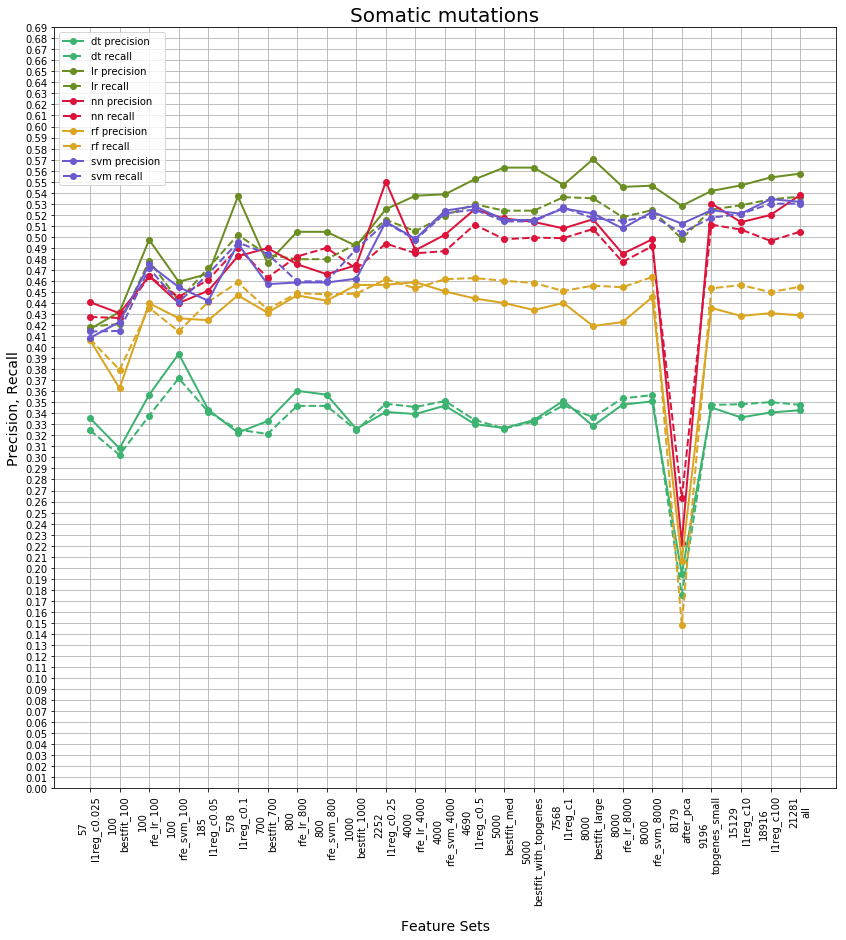

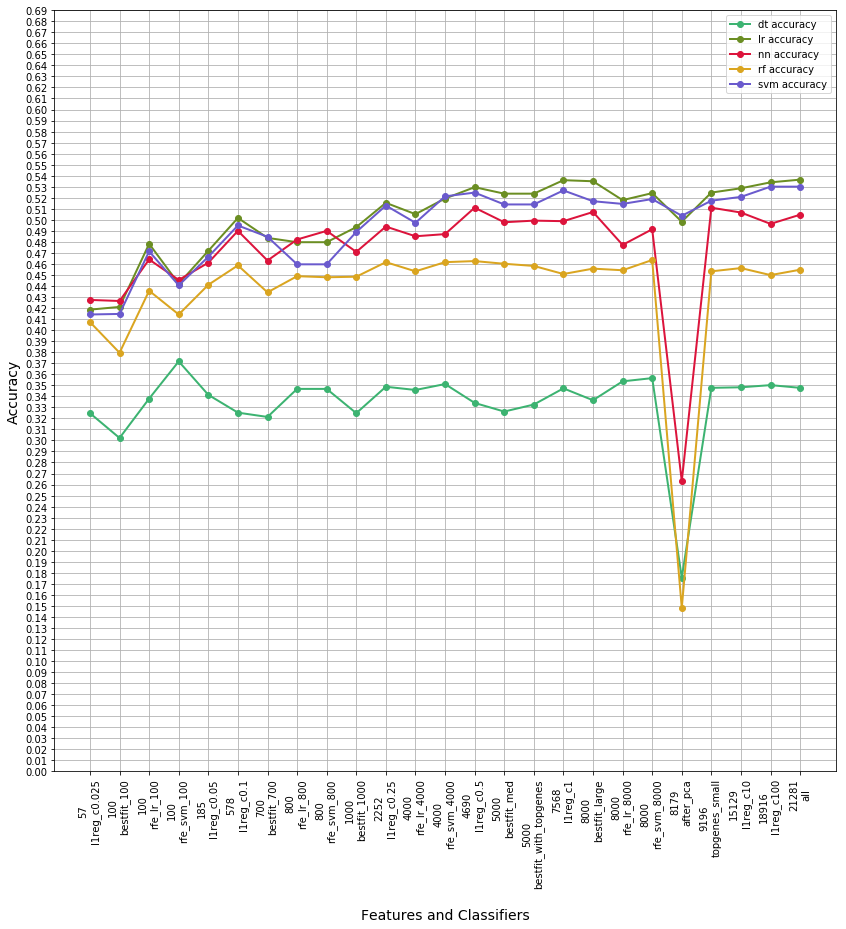

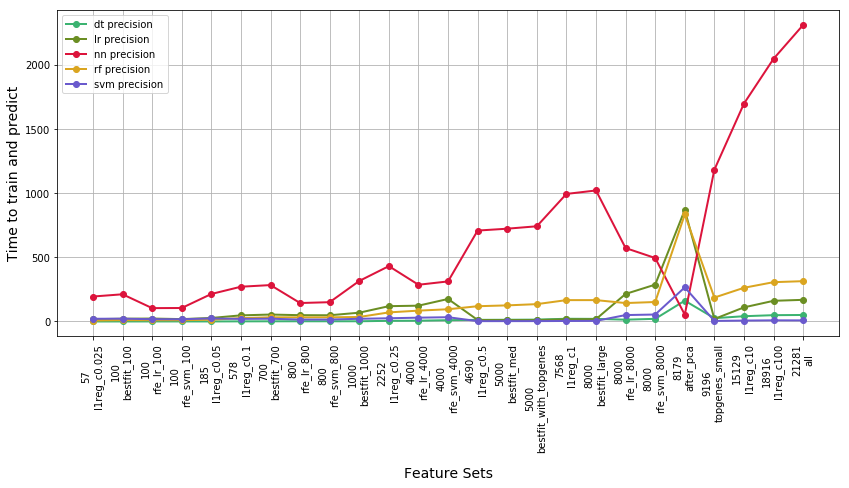

In [230]:
label_encoder   = preprocessing.LabelEncoder()

metrics_df = metrics_df[~metrics_df.name.isin(['cna_alone'])]
                        
somatic_metrics = metrics_df[~metrics_df.name.isin([
                                                    'cna_l1reg_c0.025', 
                                                    'cna_l1reg_c0.01', 
                                                    'cna_binary_l1reg_c0.025',
                                                    'cna_binary_l1reg_c0.01'])]
cna_metrics     = metrics_df[metrics_df.name.isin( ['cna_l1reg_c0.025', 
                                                    'cna_l1reg_c0.01', 
                                                    'cna_binary_l1reg_c0.025',
                                                    'cna_binary_l1reg_c0.01'])]
# Plot precision, recall, accuracy across different classifiers
# for somatic mutations
plot_classifier_metrics(somatic_metrics, label_encoder, 'Somatic mutations')

# Plot time across different classifiers
# for somatic mutations
plot_classifier_times(somatic_metrics, label_encoder, 'Somatic mutations')


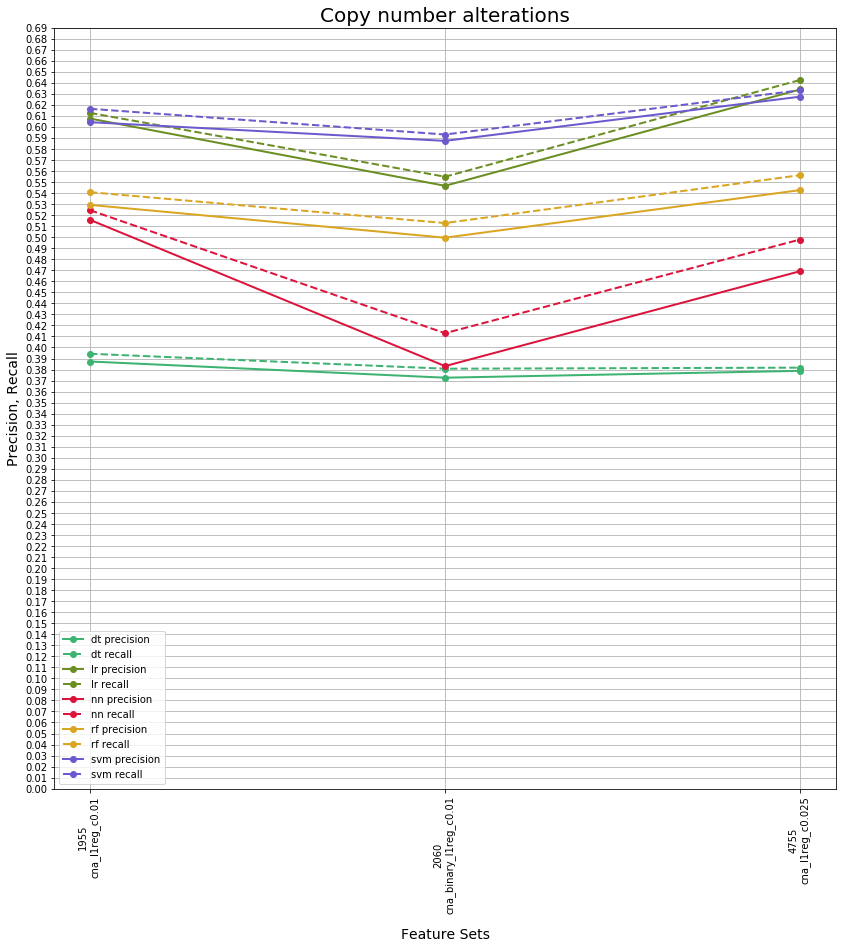

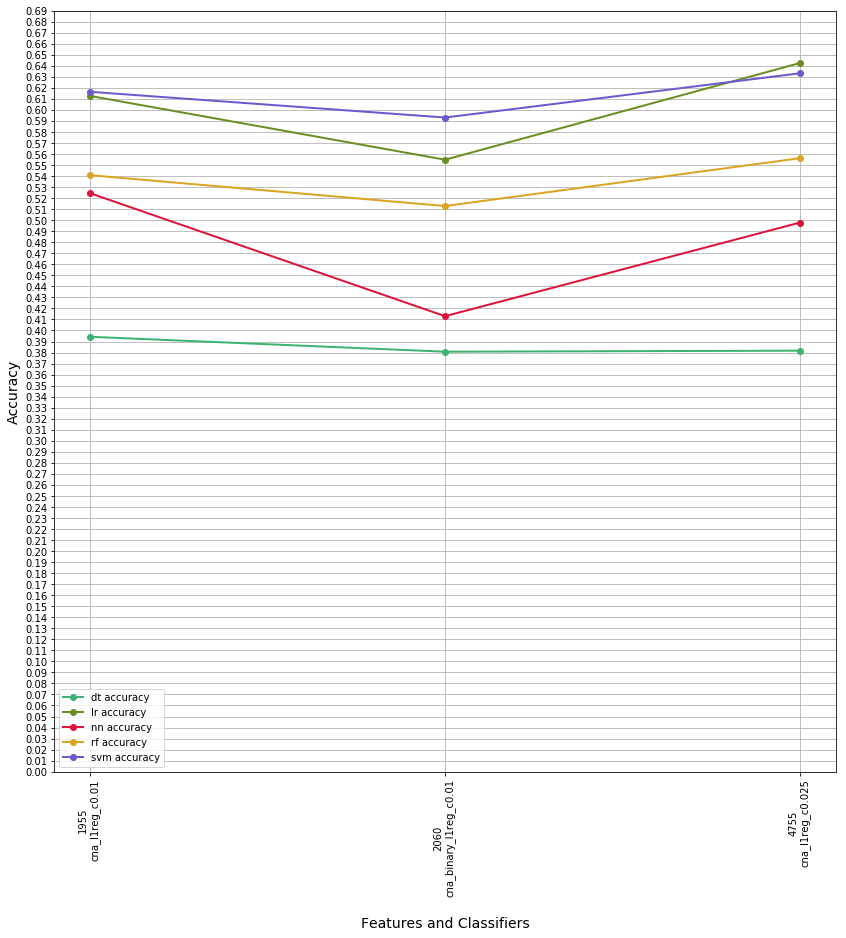

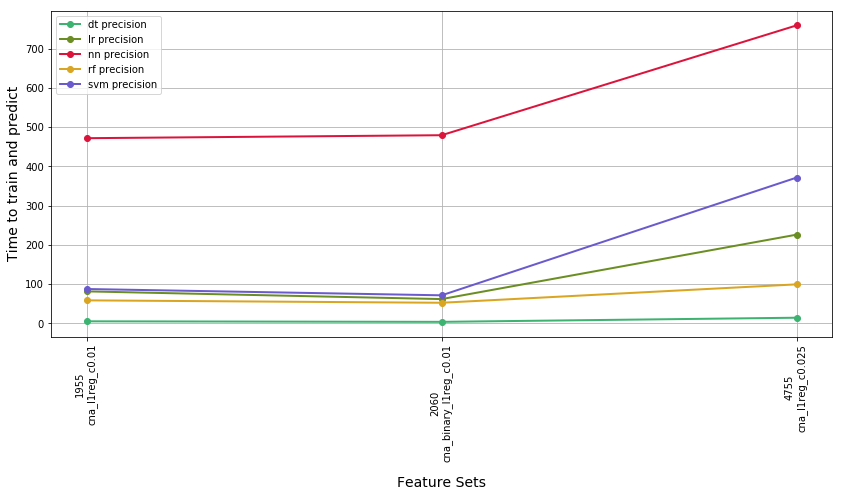

In [82]:


# Plot precision, recall, accuracy across different classifiers
# for copy number alterations
plot_classifier_metrics(cna_metrics, label_encoder, 'Copy number alterations')

# Plot time across different classifiers
# for copy number alterations
plot_classifier_times(cna_metrics, label_encoder, 'Copy number alterations')

### Report the precision, recall, and f1 score across different classifiers and feature sets



Best precision


,name,classifier,feature_size,accuracy,precision,recall,f1,time
71,bestfit_large,lr,8000,0.534963,0.570291,0.534963,0.514705,18.375221




Best recall


,name,classifier,feature_size,accuracy,precision,recall,f1,time
96,all,lr,21281,0.53643,0.557292,0.53643,0.515479,168.694119




Best f1


,name,classifier,feature_size,accuracy,precision,recall,f1,time
66,l1reg_c1,lr,7568,0.535941,0.547066,0.535941,0.518682,17.203682




Best accuracy


,name,classifier,feature_size,accuracy,precision,recall,f1,time
96,all,lr,21281,0.53643,0.557292,0.53643,0.515479,168.694119


LabelEncoder()



Precision and Recall by Label with Best F1 score 
Classifier: lr Feature set: bestfit_large


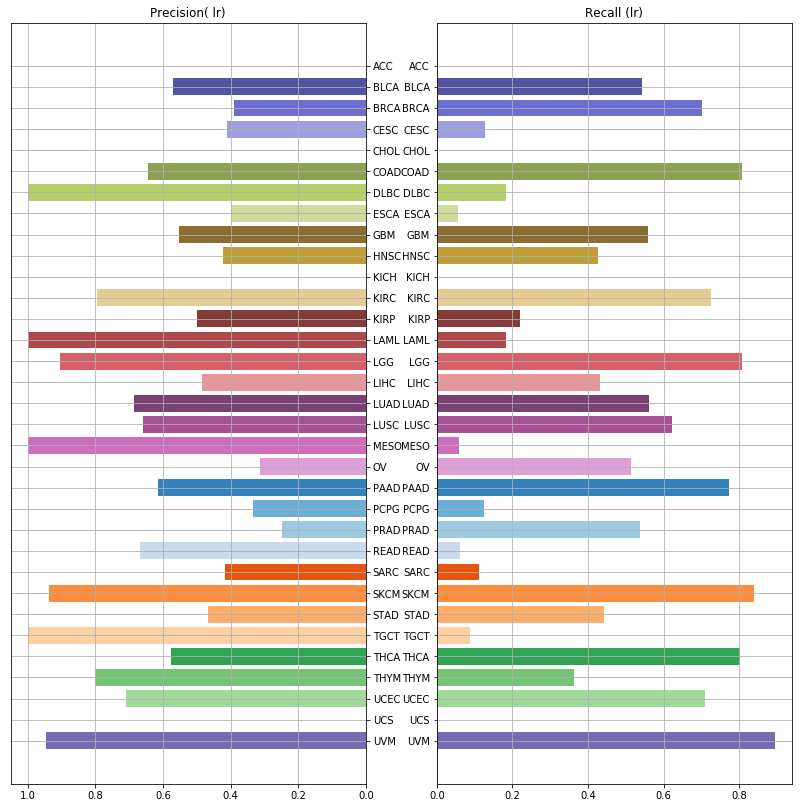

In [152]:
def show_precision_recall_by_label(prf_by_label_df, name, classifier, label_encoder):
    
    plt.rcParams["figure.figsize"] = (14,14)
    
    labels = []
    for i in range(prf_by_label_df.shape[1]):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.invert_yaxis()
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, prf_by_label_df.iloc[0].values, color=label_colors , label="precision")
    ax2.barh(y_pos, prf_by_label_df.iloc[1].values, color=label_colors,  label='recall')

    ax1.set_title('Precision( ' + classifier + ')')
    ax2.set_title('Recall (' + classifier + ')')
    ax1.grid()
    ax2.grid()
    

    plt.show()



# best precision
sorted_df = somatic_metrics.sort_values(by='precision', ascending=0)
best_precision = sorted_df.head(1)

# best recall
sorted_df = somatic_metrics.sort_values(by='recall', ascending=0)
best_recall = sorted_df.head(1)

# best f1
sorted_df = somatic_metrics.sort_values(by='f1', ascending=0)
best_f1 = sorted_df.head(1)

# best accuracy
sorted_df = somatic_metrics.sort_values(by='accuracy', ascending=0)
best_accuracy = sorted_df.head(1)


# Show the feature set and classifier with the best 
# precision, recall, and f1 scores
print("\n\nBest precision")
display(best_precision)
print("\n\nBest recall")
display(best_recall)
print("\n\nBest f1")
display(best_f1)
print("\n\nBest accuracy")
display(best_accuracy)

# get the scores by label and confusion matrix
# for the best prediction
best_prediction = best_precision
best_name       = best_prediction.name.values[0]
best_classifier = best_prediction.classifier.values[0]


best_prf_by_label_df = get_prf_by_label(best_name, best_classifier)
best_confusion_mx_df = get_confusion_matrix(best_name, best_classifier)

label_encoder.fit(feature_matrix.cancer_type.unique())

# show a side-by-side barchart of precision and recall for each label
print("\n\nPrecision and Recall by Label with Best F1 score ")
print("Classifier:", best_classifier, "Feature set:", best_name)
show_precision_recall_by_label(best_prf_by_label_df,
                               best_name, best_classifier, label_encoder)
                                                      


## Visualizations for Diagnosing Poor Performing Classes

### How many genes are in common for a cancer type?

Loading features...
.done
.................................

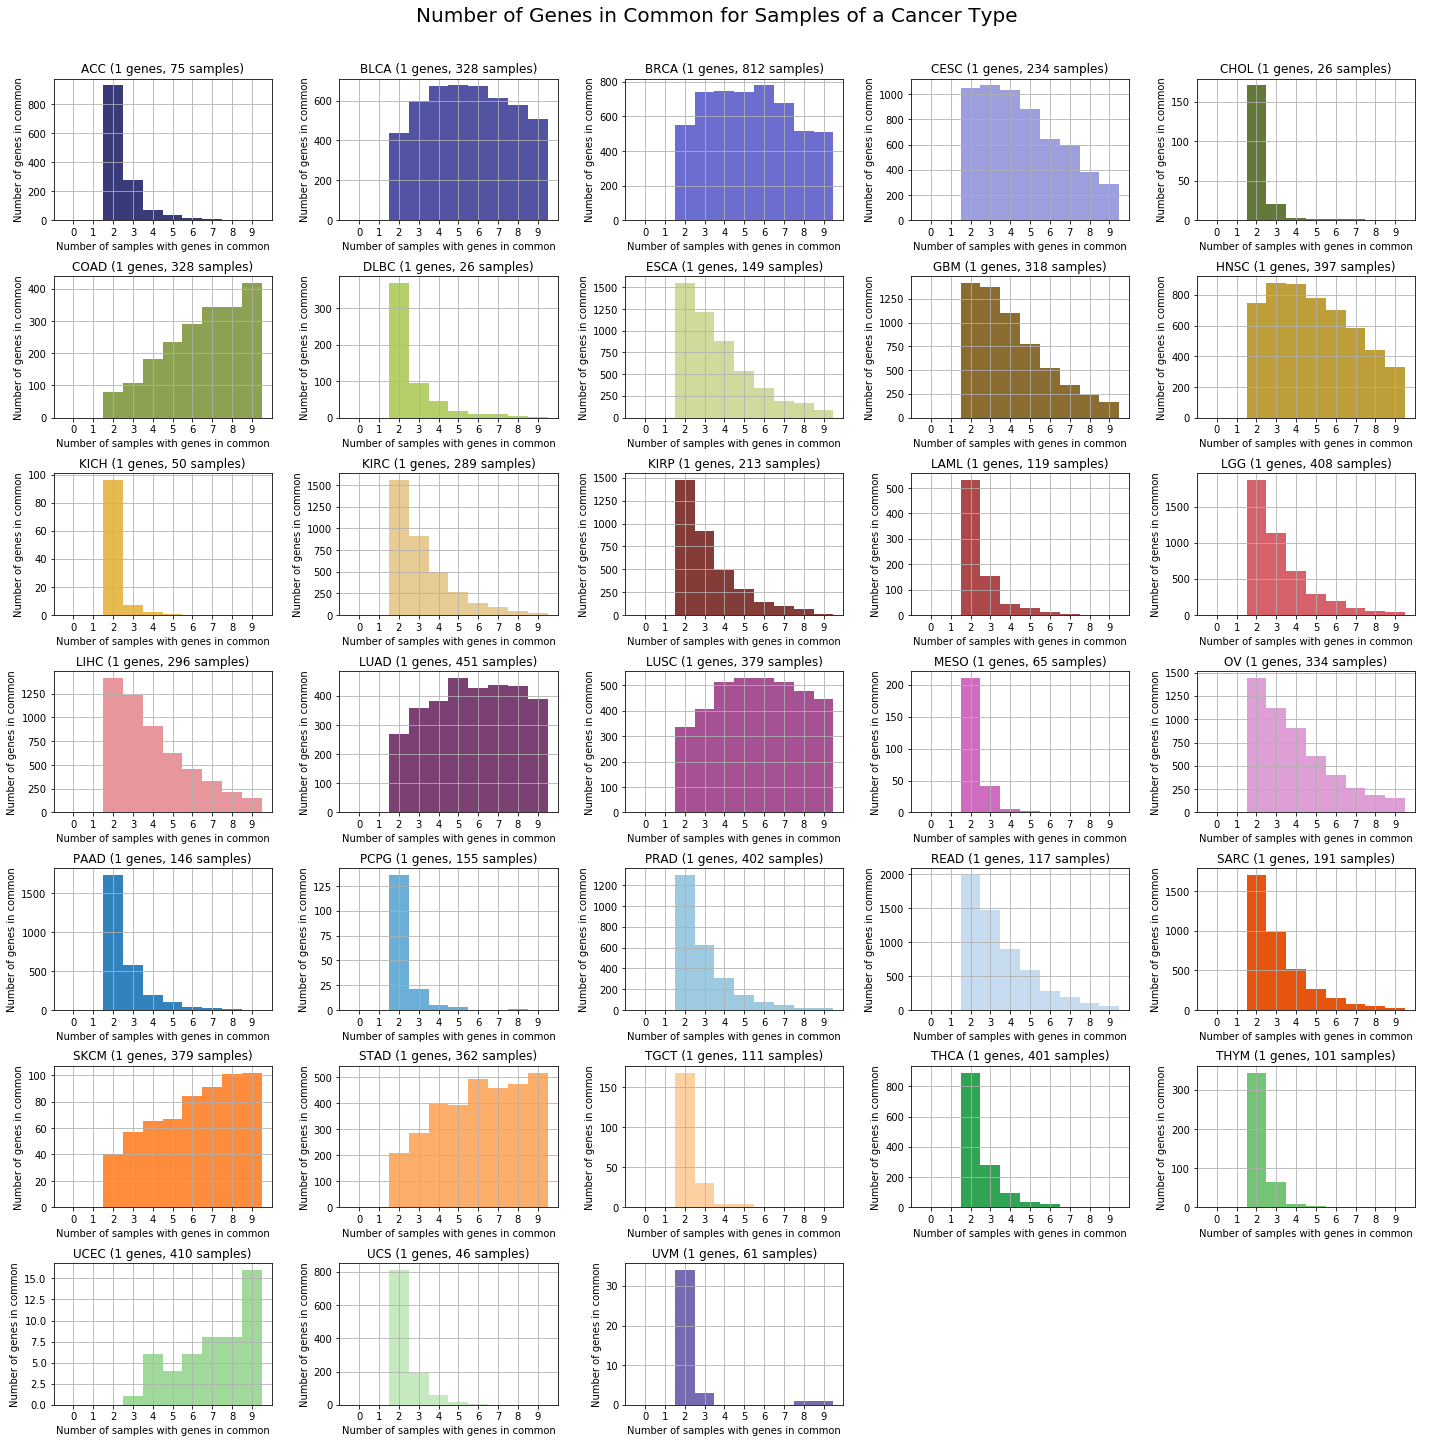

In [185]:
cancer_types = sorted(features.cancer_type.unique())
  
print("Loading features...")
feature_matrix = pd.read_csv("./data/features_" + best_name + ".train.csv")
print (".done")
features = feature_matrix[feature_matrix.columns[1:]]

plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure()
suptitle = fig.suptitle("Number of Genes in Common for Samples of a Cancer Type", fontsize=20)
ax = fig.subplots(7, 5, sharex=False, sharey=False, squeeze=True)
plt.subplots_adjust(hspace=0.4)
ax = ax.flatten()
_ = ax[33].axis('off')
_ = ax[34].axis('off')



for idx, cancer_type in enumerate(cancer_types, start=0):
  features_ct = features.loc[features.cancer_type == cancer_type]
  features_ct = features_ct[features_ct.columns[2:]]

  print(".", end='')

  gene_sums = features_ct.sum(axis=0) 
  gene_sums = gene_sums[gene_sums > 1]
  gene_sums.columns = ['gene_count']
  bins = np.arange(11) - 0.5
  _ = gene_sums.hist(ax=ax[idx], bins=bins, range=[0,11], color=label_colors[idx] )
  _ = ax[idx].set_title(cancer_type + " (" + str(len(gene_sums.columns)) 
                        + " genes, " + str(features_ct.shape[0]) + " samples)")
  _ = ax[idx].set_xlabel("Number of samples with genes in common")
  _ = ax[idx].set_xticks(np.arange(0, 10, 1))
  _ = ax[idx].set_ylabel("Number of genes in common")

_ = fig.tight_layout()
_ = suptitle.set_y(1)
_ = fig.subplots_adjust(top=.95)
plt.show()


### How many genes are common across all cancer types?

.................................

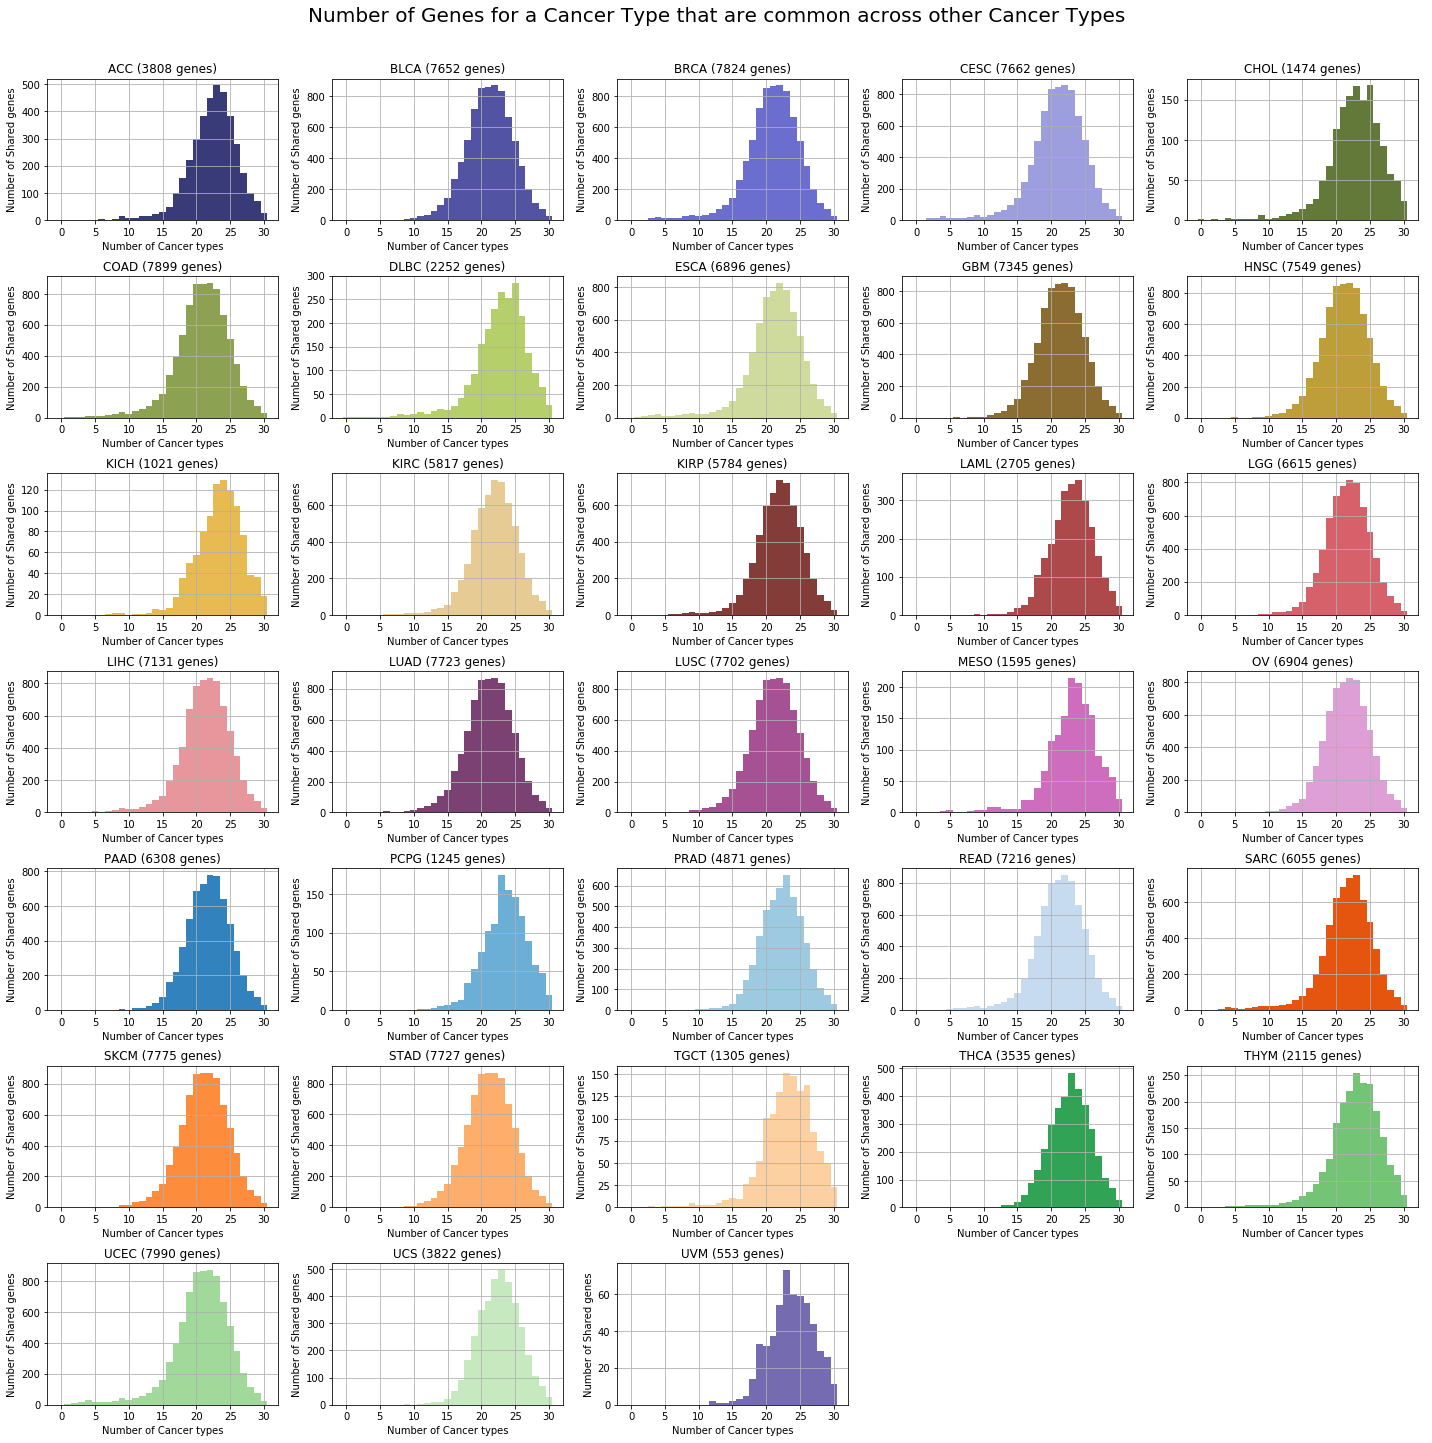

In [143]:
plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure()
suptitle = fig.suptitle("Number of Genes for a Cancer Type that are common across other Cancer Types", fontsize=20)
ax = fig.subplots(7, 5, sharex=False, sharey=False, squeeze=True)
_ = plt.subplots_adjust(hspace=0.4)
ax = ax.flatten()
_ = ax[33].axis('off')
_ = ax[34].axis('off')


features_by_cc = features[features.columns[1:]].groupby(['cancer_type']).sum()
for col in features_by_cc.columns:
  features_by_cc[col] = features_by_cc[col].apply(lambda x: 0 if x == 0 else 1)


diff_pairings = []
diff_pairings_norm = []

for idx, cancer_type in enumerate(cancer_types, start=0):
  print(".", end='')
  features_ct = features_by_cc.loc[[cancer_type]]
  
  gene_counts_ct = features_ct.T
  non_zero_genes = list(gene_counts_ct[gene_counts_ct[cancer_type] > 0].index)
  
  other_cancer_types = [c for c in cancer_types if c != cancer_type]
  features_other = features_by_cc.loc[other_cancer_types, non_zero_genes]
  
  gene_sums_ct = features_ct.sum(axis=0) 
  gene_sums_ct = gene_sums_ct[gene_sums_ct > 0]
  gene_sums_ct.columns = ['gene_count']
  
  gene_sums_other = features_other.sum(axis=0) 
  gene_sums_other = gene_sums_other[gene_sums_ct > 0]
  gene_sums_other.columns = ['gene_count']
  
  sums_other     = features_other.sum(axis=0)
  
  
  diff_pairing       = []
  diff_pairing_norm  = []
  for x, cancer_type_pairing in enumerate(cancer_types, start=0):
    features_pairing    = features_by_cc.loc[[cancer_type_pairing]]
    gene_counts_pairing = features_pairing.T
    non_zero_target     = set(non_zero_genes)
    non_zero_other      = list(gene_counts_pairing[gene_counts_pairing[cancer_type_pairing] > 0].index)
    non_zero_other      = set(non_zero_other)
  
    diff = non_zero_target - non_zero_other
    
    diff_pairing.append(len(diff))
    diff_pairing_norm.append(np.round(len(diff) / len(non_zero_target), 2))
    
  diff_pairings.append(diff_pairing)
  diff_pairings_norm.append(diff_pairing_norm)
  
  bins = np.arange(32) - 0.5
  _ = sums_other.hist(ax=ax[idx], bins=bins, range=[0,33], color=label_colors[idx])
  _ = ax[idx].set_title(cancer_type + " (" + str(gene_sums_ct.shape[0]) + " genes)")
  _ = ax[idx].set_xlabel("Number of Cancer types")
  _ = ax[idx].set_ylabel("Number of Shared genes")

  
fig.tight_layout()
suptitle.set_y(1)
fig.subplots_adjust(top=.95)
plt.show()




### Pairwise comparison of cancer types with number of genes in common

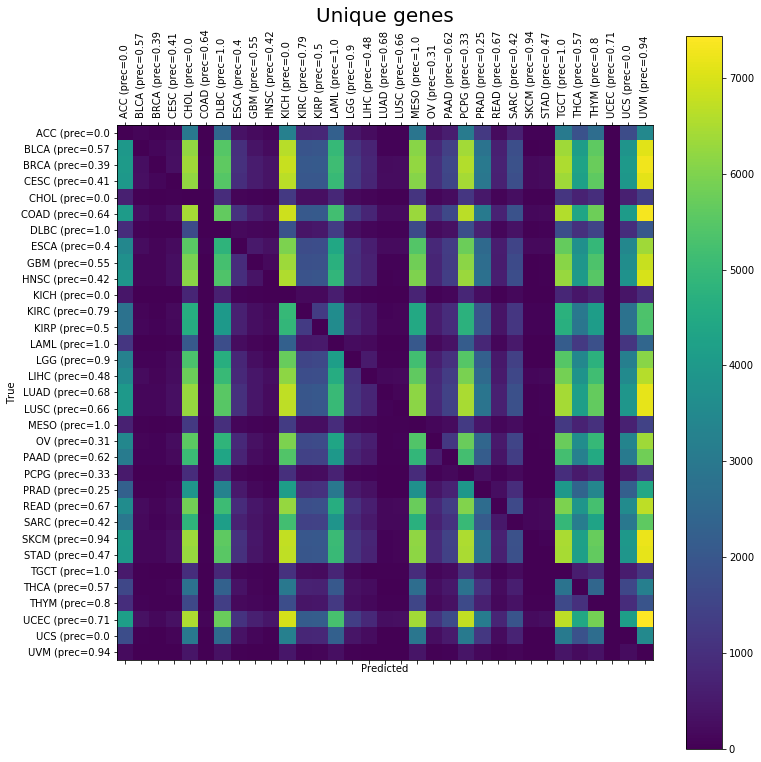

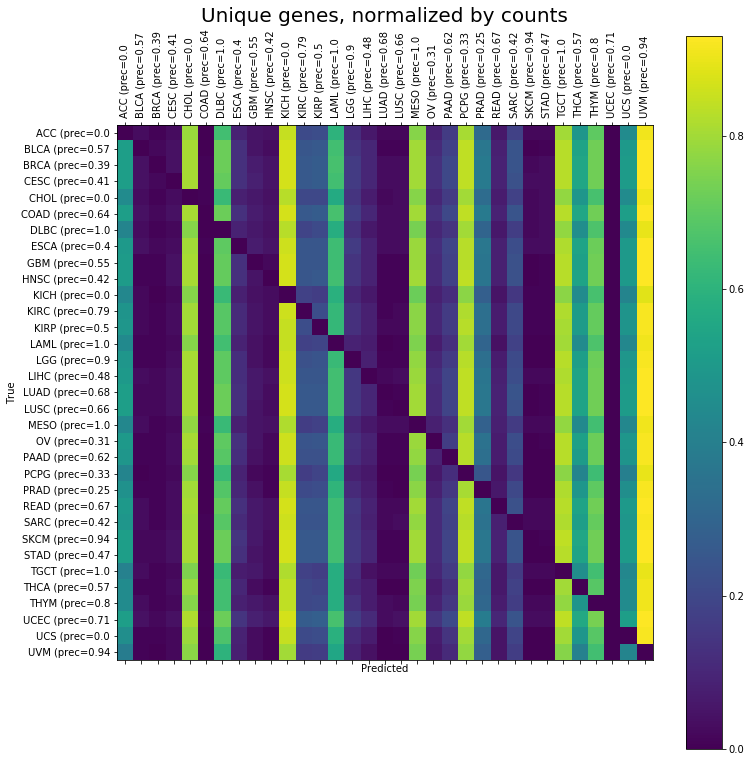

In [202]:
best_prec = np.round(best_prf_by_label_df.loc[0:0].values[0], 2)
informative_labels = []
for i in range(len(cancer_types)):
  informative_labels.append(cancer_types[i] + " (prec=" + str(best_prec[i]))
  
def plot_pairwise_comparison(pairings, title):
  pairing_df = pd.DataFrame(pairings, columns=informative_labels, index=informative_labels)

  plt.rcParams["figure.figsize"] = (12,12)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(pairing_df)
  the_title = plt.title(title, fontsize=20)
  _ = fig.colorbar(cax)
  _ = ax.set_xticks(np.arange(0, 33, 1.0))
  _ = ax.set_yticks(np.arange(0, 33, 1.0))
  _ = ax.set_xticklabels(informative_labels, rotation='vertical')
  _ = ax.set_yticklabels(informative_labels)
  _ = plt.xlabel('Predicted')
  _ = plt.ylabel('True')
  _ = the_title.set_y(1.18)
  _ = fig.subplots_adjust(top=.95)
  plt.show()

plot_pairwise_comparison(diff_pairings, "Unique genes")
plot_pairwise_comparison(diff_pairings_norm, "Unique genes, normalized by counts")

### Show the confusion matrix for the best performing classifier/feature set

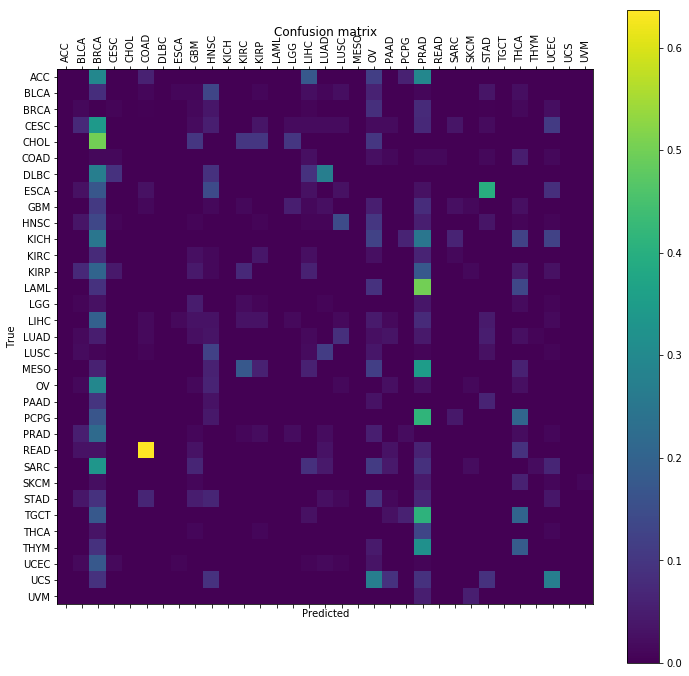

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.636364,21
1,LAML,PRAD,Acute_Myeloid_Leukemia,Prostate_adenocarcinoma,0.500000,11
2,CHOL,BRCA,Cholangiocarcinoma,Breast_invasive_carcinoma,0.500000,5
3,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.416667,10
4,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.411765,14
5,ESCA,STAD,Esophageal_carcinoma,Stomach_adenocarcinoma,0.400000,14
6,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.352941,6
7,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.345455,19
8,SARC,BRCA,Sarcoma,Breast_invasive_carcinoma,0.333333,15
9,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.318182,7


In [115]:
def show_confusion_matrix(conf_mx, label_encoder):


  
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    
    plt.rcParams["figure.figsize"] = (12,12)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(norm_conf_mx)
    _ = plt.title('Confusion matrix')
    _ = fig.colorbar(cax)
    _ = ax.set_xticks(np.arange(0, 33, 1.0))
    _ = ax.set_yticks(np.arange(0, 33, 1.0))
    _ = ax.set_xticklabels(cancer_types, rotation='vertical')
    _ = ax.set_yticklabels(cancer_types)
    _ = plt.xlabel('Predicted')
    _ = plt.ylabel('True')
    plt.show()
    
    max_coords = coords_of_max(norm_conf_mx, 20)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ actual_label,                     
                     predicted_label,
                     code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted',  'actual_name', 'predicted_name', 'error_rate', 'error_count'])
    display(df)
    

cols = [c for c in best_confusion_mx_df.columns]
best_confusion_mx = best_confusion_mx_df[cols].values
show_confusion_matrix(best_confusion_mx, label_encoder)                                                      

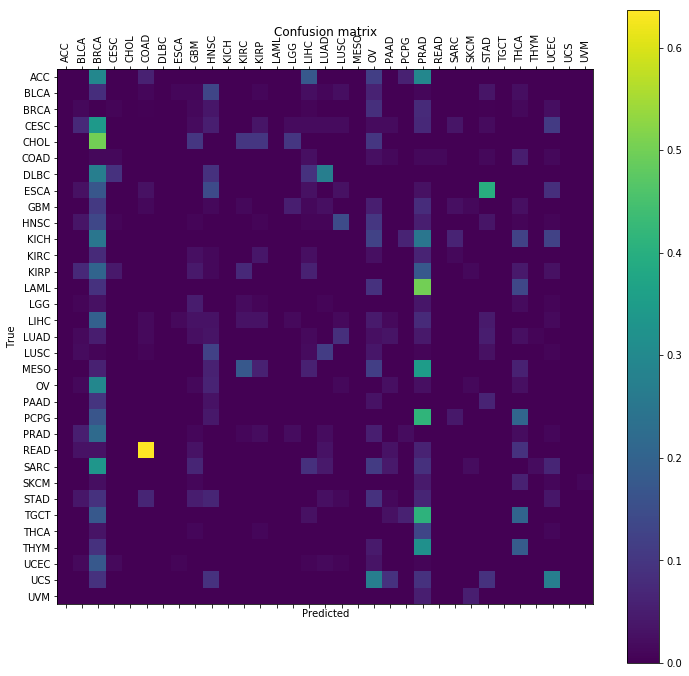

In [114]:

# Determine the error rates for each misclassification pair
row_sums = best_confusion_mx.sum(axis=1, keepdims=True)
norm_conf_mx = best_confusion_mx / row_sums
# Set the error rates for correctly classified pairs (the diagonal) to zero
np.fill_diagonal(norm_conf_mx, 0)




### TSNE Visualization

Loading mutations train...


LabelEncoder()

Plot TSNE...


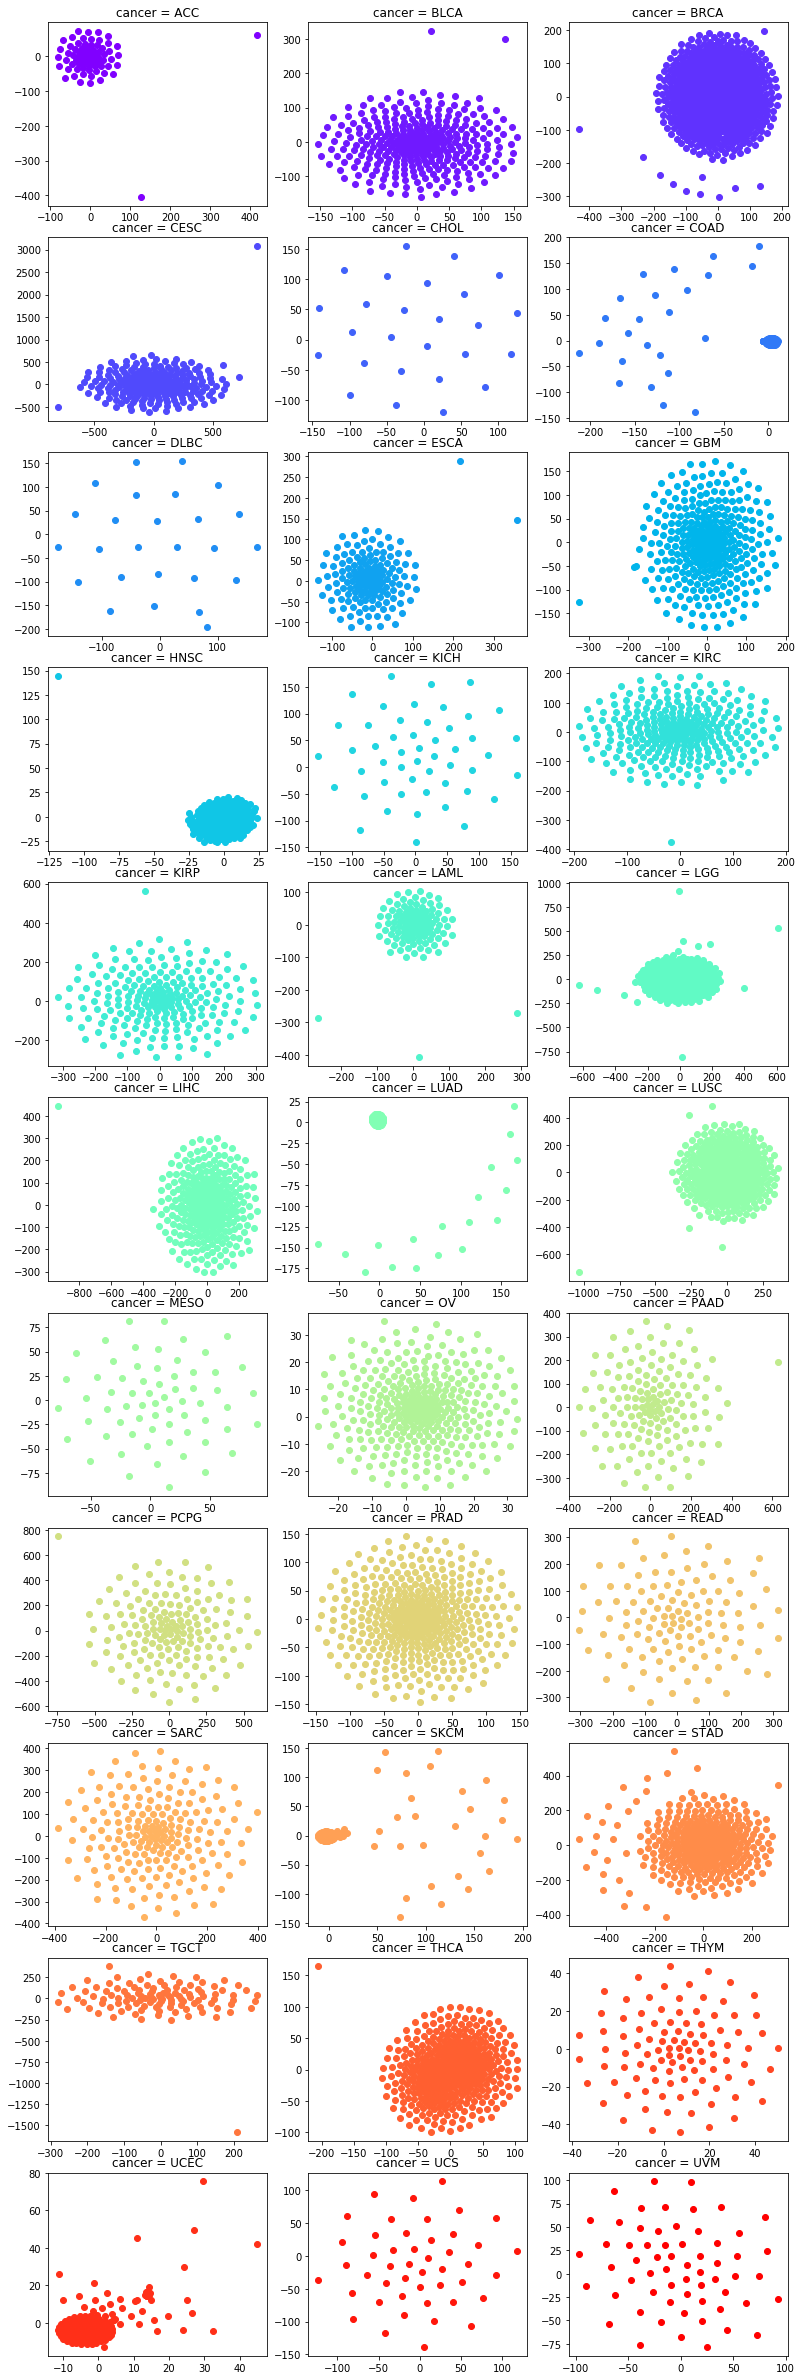

In [0]:
from sklearn.manifold import TSNE
import matplotlib as mpl

label_encoder   = preprocessing.LabelEncoder()

print("Loading mutations train...")
data = pd.read_csv("./data/features_l1reg_c1.train.csv")


labels  = list(data.cancer_type.unique())
labels.sort()
X       = data[data.columns[3:]]
label_encoder.fit(labels)

print("Plot TSNE...")
N = len(labels)
colors = mpl.cm.rainbow(np.linspace(0, 1, N))
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(11, 33))
_ = plt.tight_layout()

for i, ax in enumerate(axes.flat):
    if (i < len(labels)):
      ax.title.set_text("cancer = {}".format(labels[i]))
      d = X[data['cancer_type'] == labels[i]]
      dd = TSNE(n_components=2).fit_transform(d)
      _ = ax.scatter(dd[:,0], dd[:,1], color=colors[i])
plt.show()